### Задача

Привет! Тебе предстоит спрогнозировать поведение временных рядов в разрезе id ряда - день. Для каждого ряда требуется предоставить прогнозные значения за последние 28 дней.

К задаче приложены два файла: **train.csv** и **test.csv**.
В первом файле хранятся исторические данные семи временных рядов некоторого показателя: id - идентификатор ряда, **dt** - дата, **val** - значение временного ряда. Во втором, **test.csv** - id рядов и период, за который необходимо получить прогнозные значения показателей соответствующих рядов.

В качестве решения мы ждем два файла - **solution.csv**, который содержит в себе информацию из test.csv с дополнительной колонкой, содержащей прогнозные значения, и **.ipynb** файл, с кодом самого решения. 
Приветствуется хороший код, комментарии в коде, визуализация, оценка качества итоговой модели, наличие выводов и обоснований.

По результатам - мы вернемся с обратной связью, успехов!:)

# Небольшое предисловие
## Я попробовал и ARIMA для рядов (это видно в начале) и обычные классификаторы
## Лучшая точность получилась на RNN (см в конце)
## Но для некоторых рядов взял среднее между ARIMA и RNN

In [1]:
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm, tqdm_notebook
from itertools import product


import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pickle

from sklearn.preprocessing import MinMaxScaler
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
import scipy.stats as scs
from scipy.optimize import minimize
from pmdarima.arima import auto_arima
from keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM


from keras.preprocessing.sequence import TimeseriesGenerator

 

import matplotlib.pyplot as plt
import seaborn as sns

2023-03-16 00:19:10.803925: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-16 00:19:10.803952: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
train = pd.read_csv('train.csv', parse_dates=['dt'])
test = pd.read_csv('test.csv', parse_dates=['dt'])

In [3]:
def get_timeseries_dict(df):
    series_dict = dict()
    for series in df['id'].unique():
        series_dict[series] = df[df['id'] == series]
    return series_dict


In [4]:
train_series = get_timeseries_dict(train)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12217 entries, 0 to 12216
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   id      12217 non-null  int64         
 1   dt      12217 non-null  datetime64[ns]
 2   val     12217 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 286.5 KB


In [6]:
train_series.keys()

dict_keys([10766, 5819, 10121, 3216, 8135, 5975, 20857])

In [7]:
first = train_series[10766]

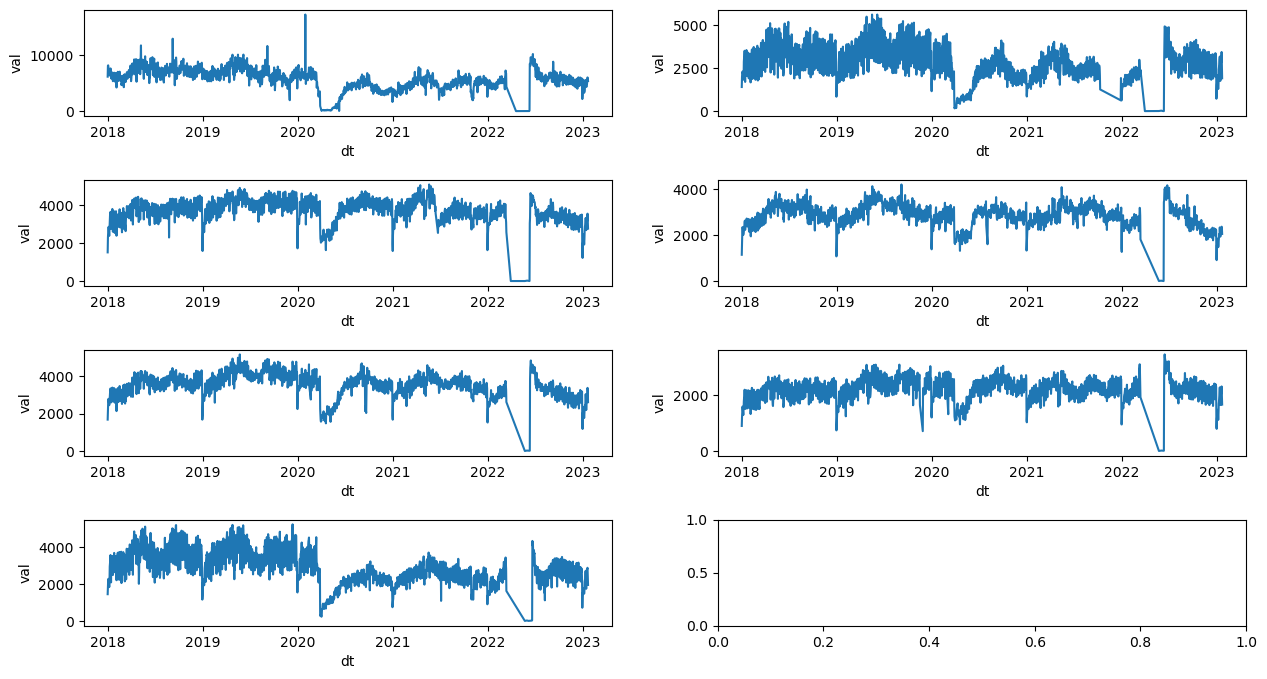

In [8]:
fig, axs = plt.subplots(
                     ncols=2,
                     nrows=4,
                     figsize=(15, 8))
fig.subplots_adjust(hspace=0.6)
i=0

axs = axs.flatten()
for key in train_series:
    sns.lineplot(x=train_series[key]['dt'], y=train_series[key]['val'], ax= axs[i])
    i+=1
plt.show()

In [9]:
data = pd.DataFrame(first)


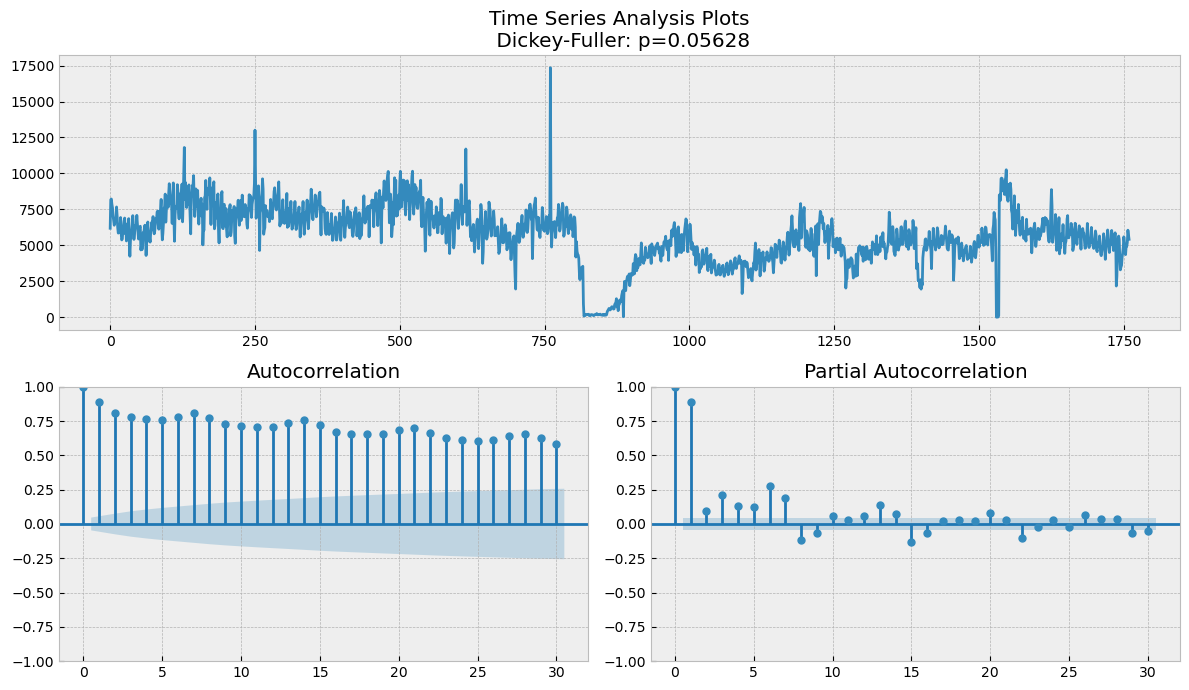

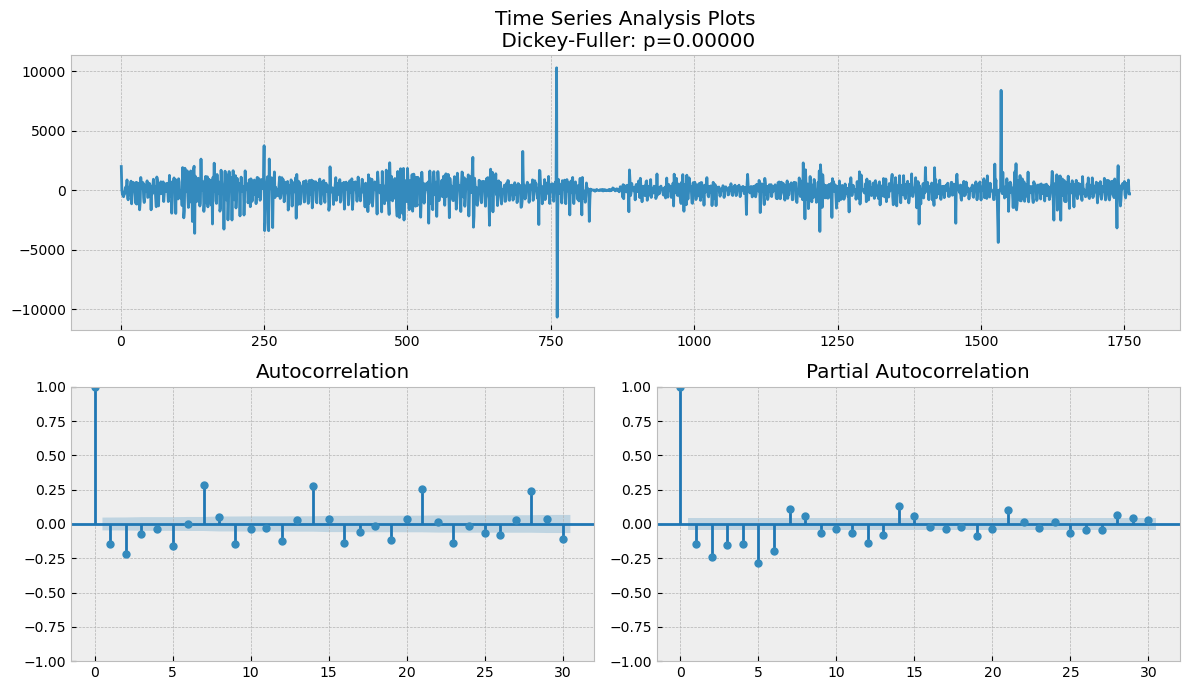

In [10]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(data.val, lags=30)

# Take the first difference to remove to make the process stationary
data_diff = data.val - data.val.shift(1)

tsplot(data_diff[1:], lags=30)

### Из графика видно, что сезонности нет.
### Наш ряд не стационарен (p > 0.05), но при первом дифференцировании ряд становится стационарным

In [11]:
# ps = range(2, 5)
# d = 1
# qs = range(0, 2)
# Ps = range(0, 5)
# D = 1
# Qs = range(0, 5)
# s = 5

# #Create a list with all possible combinations of parameters
# parameters = product(ps, qs, Ps, Qs)
# parameters_list = list(parameters)
# len(parameters_list)

# # Train many SARIMA models to find the best set of parameters
# def optimize_SARIMA(parameters_list, d, D, s):
#     """
#         Return dataframe with parameters and corresponding AIC
        
#         parameters_list - list with (p, q, P, Q) tuples
#         d - integration order
#         D - seasonal integration order
#         s - length of season
#     """
    
#     results = []
#     best_aic = float('inf')
    
#     for param in tqdm_notebook(parameters_list):
#         try: model = sm.tsa.statespace.SARIMAX(data.val, order=(param[0], d, param[1]),
#                                                seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
#         except:
#             continue
            
#         aic = model.aic
        
#         #Save best model, AIC and parameters
#         if aic < best_aic:
#             best_model = model
#             best_aic = aic
#             best_param = param
#         results.append([param, model.aic])
        
#     result_table = pd.DataFrame(results)
#     result_table.columns = ['parameters', 'aic']
#     #Sort in ascending order, lower AIC is better
#     result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
#     return result_table

# result_table = optimize_SARIMA(parameters_list, d, D, s)

# #Set parameters that give the lowest AIC (Akaike Information Criteria)
# p, q, P, Q = result_table.parameters[0]

# best_model = sm.tsa.statespace.SARIMAX(data.val, order=(p, d, q),
#                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)

# print(best_model.summary())

In [12]:
# with open('model.pkl', 'rb') as f:
#     best_model = pickle.load(f)

# Ряд стационарен, сезонности не видно, используем ARIMA

In [13]:

X_train, X_test = data[:-30], data[-30:]
stepwise_fit = auto_arima(X_train.val, trace=True, suppress_warnings=True,
                         max_P=70, max_d=30)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=28185.386, Time=0.77 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=28501.800, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=28468.365, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=28427.146, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=28499.800, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=28191.575, Time=0.38 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=28188.347, Time=0.56 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=28186.975, Time=1.33 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=28218.288, Time=0.51 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=28192.431, Time=1.25 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=28189.580, Time=1.34 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=28088.320, Time=3.29 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=28068.682, Time=2.91 sec
 ARIMA(4,1,2)(0,0,0)[0] i

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1730
Model:               SARIMAX(5, 1, 2)   Log Likelihood              -14010.884
Date:                Thu, 16 Mar 2023   AIC                          28037.767
Time:                        00:19:56   BIC                          28081.410
Sample:                             0   HQIC                         28053.910
                               - 1730                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8566      0.013     65.082      0.000       0.831       0.882
ar.L2         -0.8657      0.020    -43.330      0.000      -0.905      -0.826
ar.L3         -0.0660      0.024     -2.793      0.005      -0.112      -0.020
ar.L4         -0.2006      0.024     -8.378      0.000      -0.248      -0.154
ar.L5         -0.1206      0.018     -6.832      0.000      -0.155      -0.086
ma.L1         -1.2050      0.009   -131.858      0.000      -1.223      -1.187
ma.L2          0.9415      0.011     89.450      0.000       0.921       0.962
sigma2      6.556e+05   6918.588     94.759      0.000    6.42e+05    6.69e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             55501.93
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.99   Skew:                             1.27
Prob(H) (two-sided):                  0.95   Kurtosis:                        30.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [14]:
model_arima = ARIMA(X_train['val'], order=(5,1,2))
model_arima = model_arima.fit()
model_arima.summary()

/home/alex/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    val   No. Observations:                 1730
Model:                 ARIMA(5, 1, 2)   Log Likelihood              -14010.884
Date:                Thu, 16 Mar 2023   AIC                          28037.767
Time:                        00:19:58   BIC                          28081.410
Sample:                             0   HQIC                         28053.910
                               - 1730                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8566      0.013     65.082      0.000       0.831       0.882
ar.L2         -0.8657      0.020    -43.330      0.000      -0.905      -0.826
ar.L3         -0.0660      0.024     -2.793      0.005      -0.112      -0.020
ar.L4         -0.2006      0.024     -8.378      0.000      -0.248      -0.154
ar.L5         -0.1206      0.018     -6.832      0.000      -0.155      -0.086
ma.L1         -1.2050      0.009   -131.858      0.000      -1.223      -1.187
ma.L2          0.9415      0.011     89.450      0.000       0.921       0.962
sigma2      6.556e+05   6918.588     94.759      0.000    6.42e+05    6.69e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             55501.93
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.99   Skew:                             1.27
Prob(H) (two-sided):                  0.95   Kurtosis:                        30.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [15]:
start = len(X_train)
end = len(X_train) + len(X_test) - 1
pred = model_arima.predict(start=start, end=end, typ='levels')
pred

1730    5739.825850
1731    5165.206788
1732    4848.426218
1733    4911.939821
1734    5246.177876
1735    5649.043551
1736    5833.443117
1737    5646.042974
1738    5224.577174
1739    4892.474998
1740    4899.645569
1741    5236.465295
1742    5647.855104
1743    5825.651197
1744    5638.193671
1745    5228.107245
1746    4904.217726
1747    4908.873565
1748    5236.485921
1749    5639.347290
1750    5814.954819
1751    5633.127498
1752    5232.471909
1753    4914.752650
1754    4917.625697
1755    5236.881251
1756    5631.149203
1757    5804.372472
1758    5628.107215
1759    5236.738932
Name: predicted_mean, dtype: float64

<AxesSubplot:>

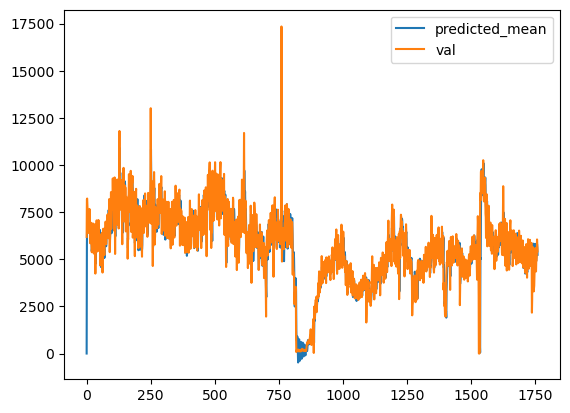

In [16]:
start = 0
end = len(X_train) + len(X_test) - 1
pred = model_arima.predict(start, end)
pred.plot(legend=True)
data['val'].plot(legend=True)

In [17]:
stepwise_fit = auto_arima(data['val'][100:], trace=True, suppress_warnings=True,
                         max_P=70, max_d=30)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=27078.180, Time=0.94 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=27381.224, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=27349.891, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=27311.749, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=27379.228, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=27084.347, Time=0.46 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=27081.186, Time=0.77 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=27085.259, Time=0.94 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=27079.655, Time=1.77 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=27110.033, Time=0.58 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=27085.199, Time=0.86 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=27082.373, Time=1.55 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.94 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=27076.276, Time=0.49 sec
 ARIMA(1,1,2)(0,0,0)[0]  

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1660
Model:               SARIMAX(2, 1, 2)   Log Likelihood              -13533.138
Date:                Thu, 16 Mar 2023   AIC                          27076.276
Time:                        00:20:15   BIC                          27103.346
Sample:                             0   HQIC                         27086.309
                               - 1660                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9519      0.099      9.641      0.000       0.758       1.145
ar.L2         -0.3907      0.047     -8.398      0.000      -0.482      -0.299
ma.L1         -1.2643      0.100    -12.643      0.000      -1.460      -1.068
ma.L2          0.4001      0.089      4.516      0.000       0.226       0.574
sigma2      6.913e+05   7575.368     91.260      0.000    6.76e+05    7.06e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             33537.35
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.79   Skew:                             0.80
Prob(H) (two-sided):                  0.01   Kurtosis:                        24.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Обучим модель с лучшими параметрами и оценим точность
## А дальше предскажем для  test выбоки

/home/alex/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


755748.1028306986


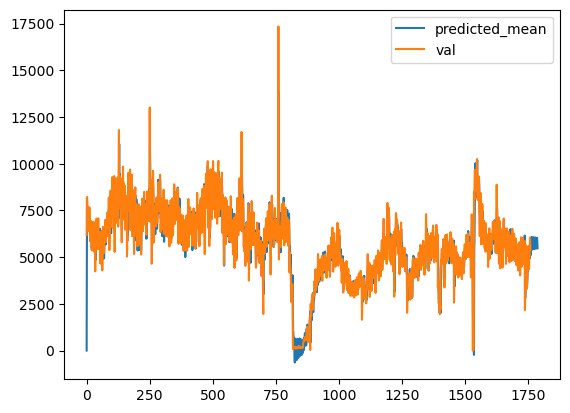

In [18]:
# 1 1 1 129427
X_train, X_test_len = data[:], 28
model_arima = ARIMA(X_train['val'], order=(6,1,4))
model_arima = model_arima.fit()
model_arima.summary()
start = 0
end = X_train.index[-1] + X_test_len
pred = model_arima.predict(start=start, end=end, typ='levels')
pred.plot(legend=True)
X_train['val'].plot(legend=True)
plt.plot()
print(mean_squared_error(X_train['val'][:-2], pred[2:1760]))

<AxesSubplot:>

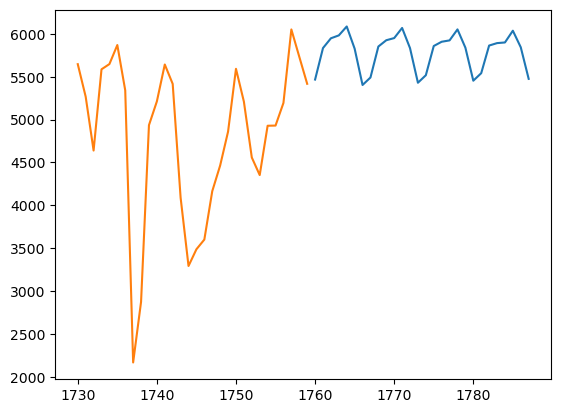

In [19]:
pred[len(data):].plot()
X_train[-30:]['val'].plot()

In [20]:
answer_10766 = pred[len(data):]
test.loc[test['id']==10766, 'val'] = answer_10766.to_numpy()

## Продолжим так же для следующих рядов

In [21]:
train_series.keys()

dict_keys([10766, 5819, 10121, 3216, 8135, 5975, 20857])

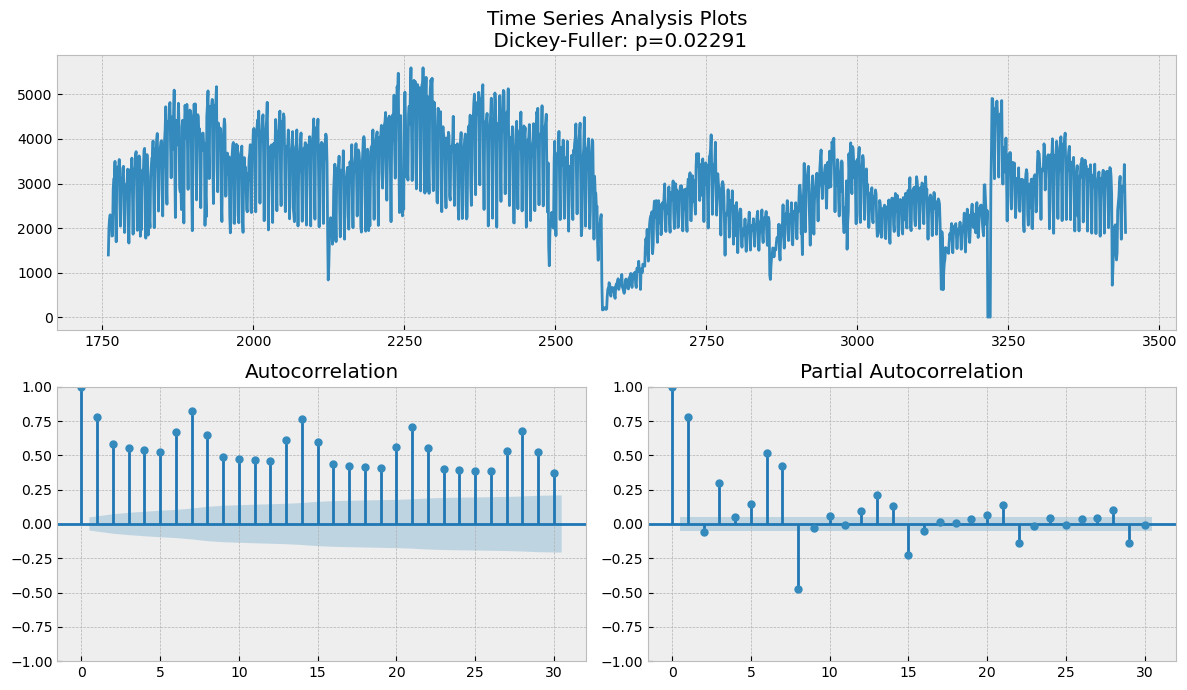

In [22]:
curr_id = 5819
data = pd.DataFrame(train_series[curr_id])
tsplot(data.val, lags=30)

In [23]:
# ряд стационарен
data = data.reset_index()
X_train, X_test = data[:-30], data[-30:]
stepwise_fit = auto_arima(X_train.val, trace=True, suppress_warnings=True,
                         max_P=70, max_d=30)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=25775.931, Time=1.96 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=26309.461, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=26305.019, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=26229.399, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=26307.466, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=25790.192, Time=2.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=25779.692, Time=1.37 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=25758.469, Time=2.59 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=25780.972, Time=1.93 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=25756.714, Time=3.13 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=25679.380, Time=1.11 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=25981.783, Time=0.29 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=25314.749, Time=2.02 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=25435.604, Time=0.71 sec
 ARIMA(5,1,2)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1655
Model:               SARIMAX(5, 1, 5)   Log Likelihood              -12352.388
Date:                Thu, 16 Mar 2023   AIC                          24728.776
Time:                        00:21:12   BIC                          24793.708
Sample:                             0   HQIC                         24752.847
                               - 1655                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.1608     14.752     -0.011      0.991     -29.074      28.753
ar.L1          0.7001      0.074      9.398      0.000       0.554       0.846
ar.L2         -1.3604      0.060    -22.630      0.000      -1.478      -1.243
ar.L3          0.6689      0.106      6.314      0.000       0.461       0.877
ar.L4         -0.9089      0.061    -14.933      0.000      -1.028      -0.790
ar.L5         -0.0871      0.073     -1.198      0.231      -0.230       0.055
ma.L1         -1.1043      0.068    -16.248      0.000      -1.238      -0.971
ma.L2          1.5786      0.064     24.718      0.000       1.453       1.704
ma.L3         -1.2633      0.091    -13.826      0.000      -1.442      -1.084
ma.L4          1.0922      0.061     17.878      0.000       0.972       1.212
ma.L5         -0.3698      0.057     -6.543      0.000      -0.481      -0.259
sigma2      2.502e+05   7125.915     35.115      0.000    2.36e+05    2.64e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):              2686.77
Prob(Q):                              0.62   Prob(JB):                         0.00
Heteroskedasticity (H):               0.61   Skew:                            -0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
model_arima = ARIMA(X_train['val'], order=(5,0,5))
model_arima = model_arima.fit()
model_arima.summary()

/home/alex/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    val   No. Observations:                 1655
Model:                 ARIMA(5, 0, 5)   Log Likelihood              -12453.946
Date:                Thu, 16 Mar 2023   AIC                          24931.892
Time:                        00:21:18   BIC                          24996.831
Sample:                             0   HQIC                         24955.965
                               - 1655                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2979.4791   1.49e-08      2e+11      0.000    2979.479    2979.479
ar.L1          1.7936      0.007    252.001      0.000       1.780       1.808
ar.L2         -2.2282      0.012   -189.907      0.000      -2.251      -2.205
ar.L3          2.2326      0.010    222.274      0.000       2.213       2.252
ar.L4         -1.7857      0.010   -178.830      0.000      -1.805      -1.766
ar.L5          0.9875      0.007    142.035      0.000       0.974       1.001
ma.L1         -1.2120      0.027    -45.549      0.000      -1.264      -1.160
ma.L2          1.6575      0.038     43.648      0.000       1.583       1.732
ma.L3         -1.3555      0.048    -28.322      0.000      -1.449      -1.262
ma.L4          1.1579      0.038     30.159      0.000       1.083       1.233
ma.L5         -0.4225      0.033    -12.891      0.000      -0.487      -0.358
sigma2      3.292e+05   5.23e-08   6.29e+12      0.000    3.29e+05    3.29e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.49   Jarque-Bera (JB):              2880.00
Prob(Q):                              0.48   Prob(JB):                         0.00
Heteroskedasticity (H):               0.63   Skew:                            -0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.69e+28. Standard errors may be unstable.
"""

<AxesSubplot:>

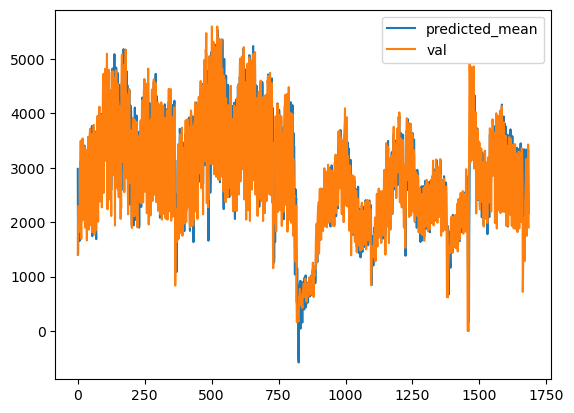

In [25]:
start = len(X_train)
end = len(X_train) + len(X_test) - 1
pred = model_arima.predict(start=start, end=end, typ='levels')

start = 0
end = len(X_train) + len(X_test) - 1
pred = model_arima.predict(start, end)
pred.plot(legend=True)
data['val'].plot(legend=True)

In [26]:
stepwise_fit = auto_arima(data['val'][100:], trace=True, suppress_warnings=True,
                         max_P=70, max_d=30)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=24686.952, Time=1.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=25187.966, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=25184.194, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=25123.709, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=25185.974, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=24699.437, Time=0.83 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=24690.970, Time=0.79 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=24673.046, Time=1.63 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=24692.039, Time=1.20 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=24674.421, Time=2.40 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=24321.959, Time=2.79 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=24385.701, Time=2.22 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=24166.936, Time=2.62 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=23821.403, Time=2.92 sec
 ARIMA(5,1,2)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1585
Model:               SARIMAX(5, 1, 5)   Log Likelihood              -11825.264
Date:                Thu, 16 Mar 2023   AIC                          23672.528
Time:                        00:22:15   BIC                          23731.573
Sample:                             0   HQIC                         23694.464
                               - 1585                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4781      0.086      5.528      0.000       0.309       0.648
ar.L2         -1.1833      0.069    -17.038      0.000      -1.319      -1.047
ar.L3          0.3472      0.124      2.806      0.005       0.105       0.590
ar.L4         -0.7337      0.070    -10.470      0.000      -0.871      -0.596
ar.L5         -0.3099      0.085     -3.636      0.000      -0.477      -0.143
ma.L1         -0.8558      0.084    -10.140      0.000      -1.021      -0.690
ma.L2          1.3501      0.081     16.599      0.000       1.191       1.510
ma.L3         -0.8659      0.119     -7.298      0.000      -1.098      -0.633
ma.L4          0.8714      0.074     11.792      0.000       0.727       1.016
ma.L5         -0.1192      0.072     -1.649      0.099      -0.261       0.022
sigma2       2.46e+05   6898.315     35.654      0.000    2.32e+05    2.59e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):              2554.04
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               0.63   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/home/alex/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


752548.686932036


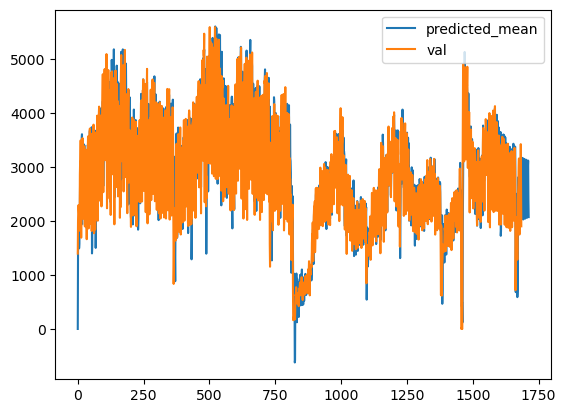

In [27]:
X_train, X_test_len = data[:], 28
model_arima = ARIMA(X_train['val'], order=(5,1,5))
model_arima = model_arima.fit()
model_arima.summary()
start = 0
end = X_train.index[-1] + X_test_len
pred = model_arima.predict(start=start, end=end, typ='levels')
pred.plot(legend=True)
X_train['val'].plot(legend=True)
plt.plot()
print(mean_squared_error(X_train['val'][:-2], pred[2:len(X_train)]))

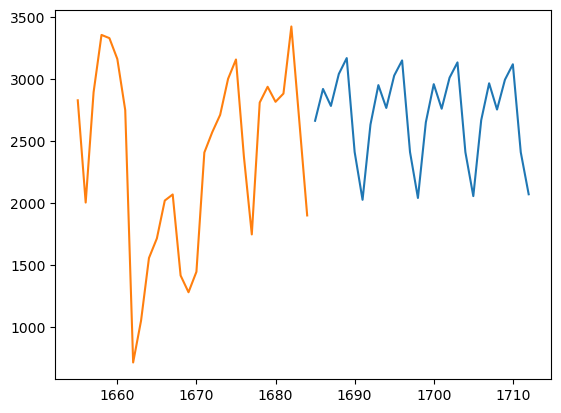

In [28]:
pred[len(data):].plot()
X_train[-30:]['val'].plot()
answer_10766 = pred[len(data):]
test.loc[test['id']==curr_id, 'val'] = answer_10766.to_numpy()

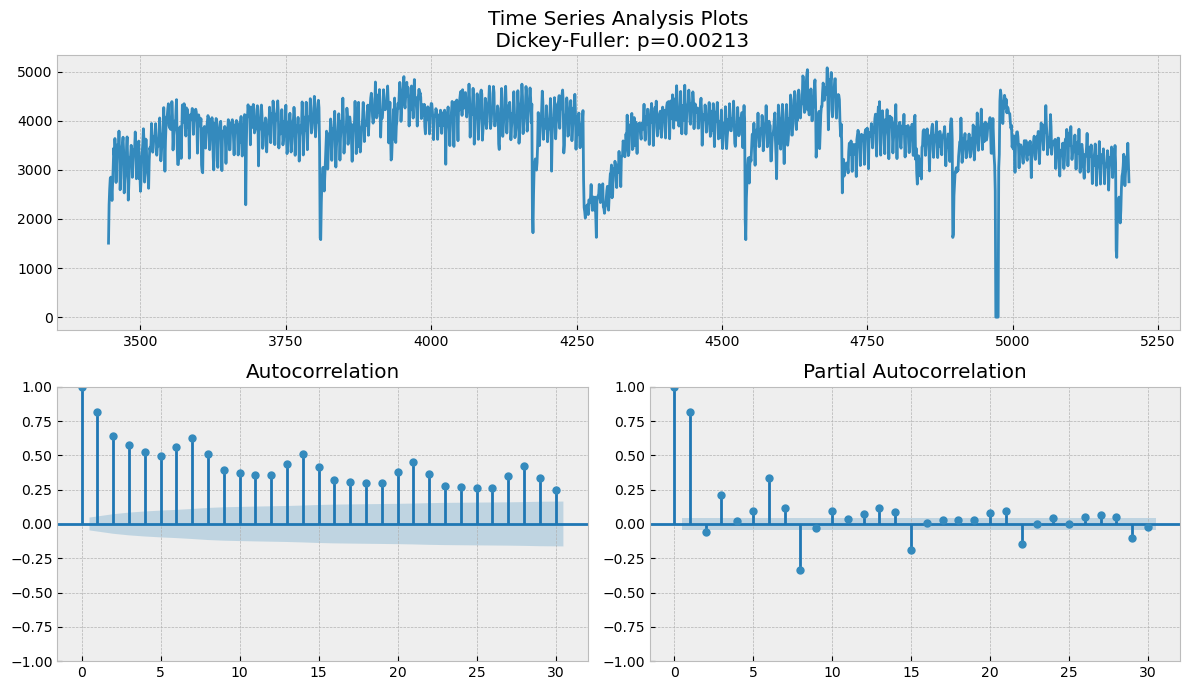

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=24859.037, Time=1.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=25146.576, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=25146.495, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=25143.529, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=25144.594, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=24857.437, Time=0.56 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=24896.715, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=24929.945, Time=0.50 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=24858.853, Time=1.91 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=24858.509, Time=1.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=24872.313, Time=1.01 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=24861.438, Time=0.84 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=24855.502, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=24894.747, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1726
Model:               SARIMAX(1, 1, 2)   Log Likelihood              -12423.751
Date:                Thu, 16 Mar 2023   AIC                          24855.502
Time:                        00:22:31   BIC                          24877.314
Sample:                             0   HQIC                         24863.571
                               - 1726                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3635      0.026     13.776      0.000       0.312       0.415
ma.L1         -0.5154      0.026    -19.491      0.000      -0.567      -0.464
ma.L2         -0.3275      0.021    -15.507      0.000      -0.369      -0.286
sigma2      1.037e+05   1645.968     63.005      0.000       1e+05    1.07e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              5871.15
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.17   Skew:                            -1.09
Prob(H) (two-sided):                  0.06   Kurtosis:                        11.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
curr_id = 10121
data = pd.DataFrame(train_series[curr_id])
tsplot(data.val, lags=30)
plt.show()
# ряд стационарен
data = data.reset_index()
X_train, X_test = data[:-30], data[-30:]
stepwise_fit = auto_arima(X_train.val, trace=True, suppress_warnings=True,
                         max_P=70, max_d=30)
stepwise_fit.summary()

/home/alex/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


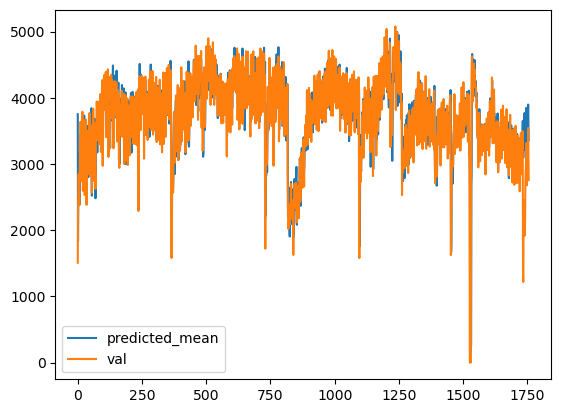

In [30]:
model_arima = ARIMA(X_train['val'], order=(6,0,4))
model_arima = model_arima.fit()
model_arima.summary()
start = len(X_train)
end = len(X_train) + len(X_test) - 1
pred = model_arima.predict(start=start, end=end, typ='levels')

start = 0
end = len(X_train) + len(X_test) - 1
pred = model_arima.predict(start, end)
pred.plot(legend=True)
data['val'].plot(legend=True)
plt.show()

/home/alex/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


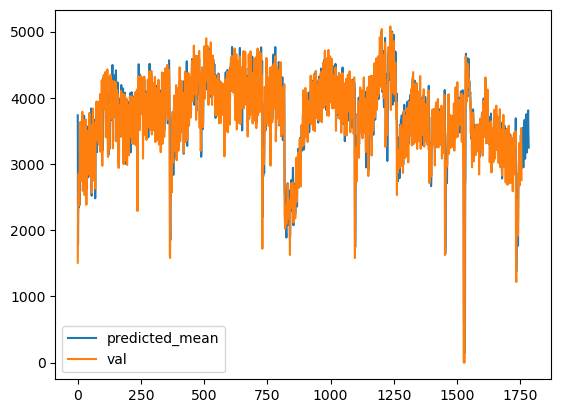

169085.32519632883


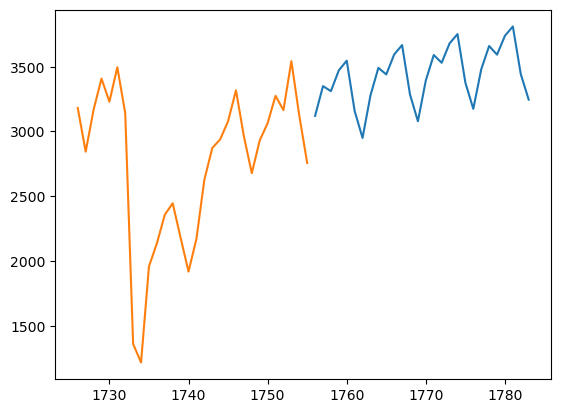

In [31]:
X_train, X_test_len = data[:], 28
model_arima = ARIMA(X_train['val'], order=(6,0,4))
model_arima = model_arima.fit()
model_arima.summary()
start = 0
end = X_train.index[-1] + X_test_len
pred = model_arima.predict(start=start, end=end, typ='levels')
pred.plot(legend=True)
X_train['val'].plot(legend=True)
plt.show()

print(mean_squared_error(X_train['val'][:-2], pred[2:len(X_train)]))

pred[len(data):].plot()
X_train[-30:]['val'].plot()
answer_10766 = pred[len(data):]
test.loc[test['id']==curr_id, 'val'] = answer_10766.to_numpy()
plt.show()

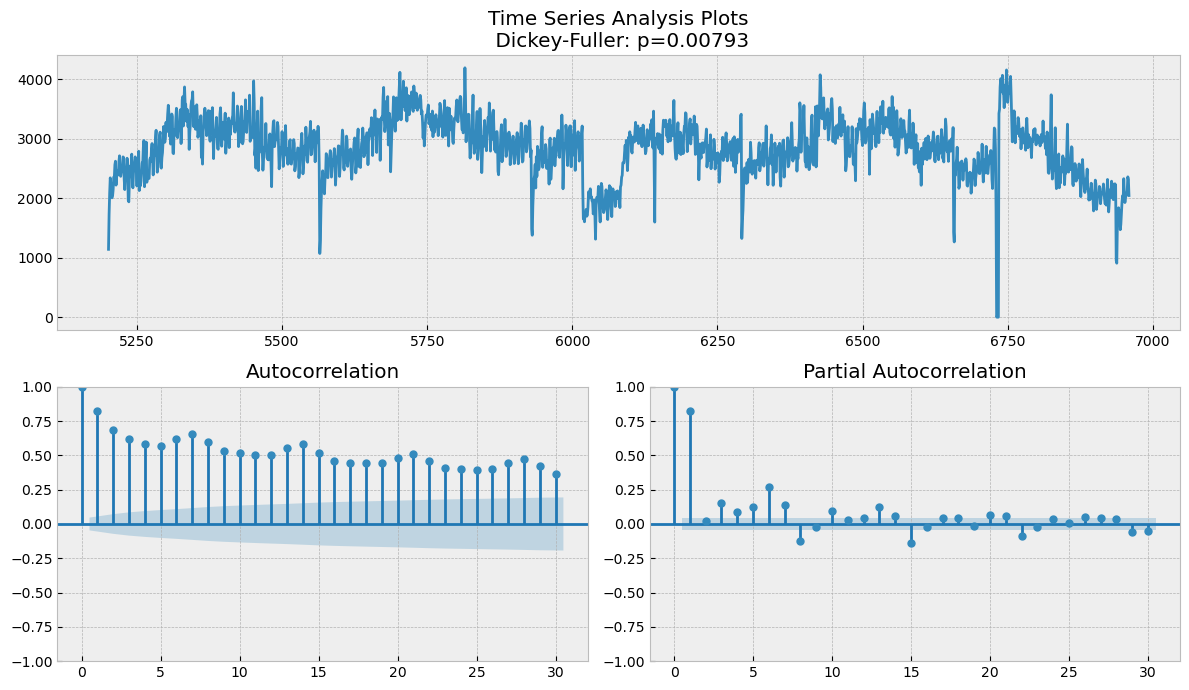

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=24185.608, Time=1.38 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=24483.578, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=24466.290, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=24448.937, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=24481.587, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=24188.856, Time=0.29 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=24186.521, Time=0.57 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=24190.473, Time=1.55 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=24187.457, Time=2.14 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=24217.489, Time=0.60 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=24190.004, Time=1.47 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=24187.943, Time=1.14 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=24072.831, Time=2.82 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=24049.386, Time=3.04 sec
 ARIMA(4,1,2)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1729
Model:               SARIMAX(5, 1, 3)   Log Likelihood              -11995.597
Date:                Thu, 16 Mar 2023   AIC                          24009.194
Time:                        00:23:28   BIC                          24058.286
Sample:                             0   HQIC                         24027.353
                               - 1729                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1750      0.023      7.536      0.000       0.129       0.221
ar.L2         -0.7880      0.019    -40.848      0.000      -0.826      -0.750
ar.L3          0.4193      0.030     14.069      0.000       0.361       0.478
ar.L4         -0.1439      0.019     -7.450      0.000      -0.182      -0.106
ar.L5         -0.1683      0.018     -9.245      0.000      -0.204      -0.133
ma.L1         -0.3996      0.017    -23.262      0.000      -0.433      -0.366
ma.L2          0.6140      0.012     52.123      0.000       0.591       0.637
ma.L3         -0.8144      0.019    -43.799      0.000      -0.851      -0.778
sigma2      6.472e+04   1025.994     63.080      0.000    6.27e+04    6.67e+04
===================================================================================
Ljung-Box (L1) (Q):                   1.18   Jarque-Bera (JB):             14582.98
Prob(Q):                              0.28   Prob(JB):                         0.00
Heteroskedasticity (H):               1.72   Skew:                            -0.59
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [32]:
curr_id = 3216
data = pd.DataFrame(train_series[curr_id])
tsplot(data.val, lags=30)
plt.show()
# ряд стационарен
data = data.reset_index()
X_train, X_test = data[:-30], data[-30:]
stepwise_fit = auto_arima(X_train.val, trace=True, suppress_warnings=True,
                         max_P=70, max_d=30)
stepwise_fit.summary()

/home/alex/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


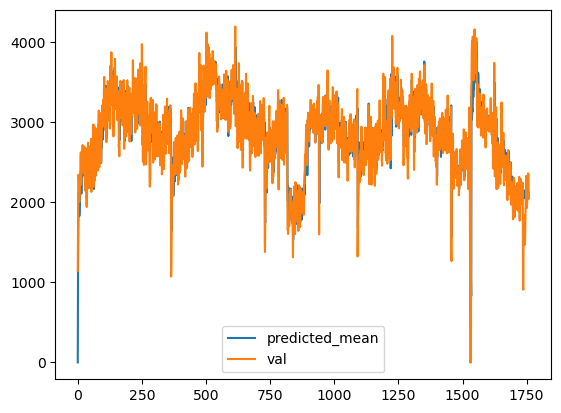

In [33]:
model_arima = ARIMA(X_train['val'], order=(5,1,3))
model_arima = model_arima.fit()
model_arima.summary()
start = len(X_train)
end = len(X_train) + len(X_test) - 1
pred = model_arima.predict(start=start, end=end, typ='levels')

start = 0
end = len(X_train) + len(X_test) - 1
pred = model_arima.predict(start, end)
pred.plot(legend=True)
data['val'].plot(legend=True)
plt.show()

/home/alex/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


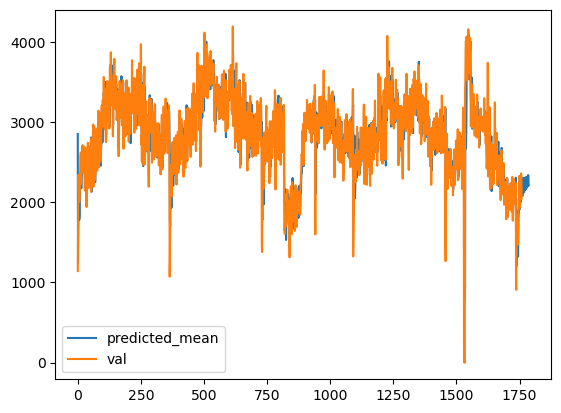

84363.80239534337


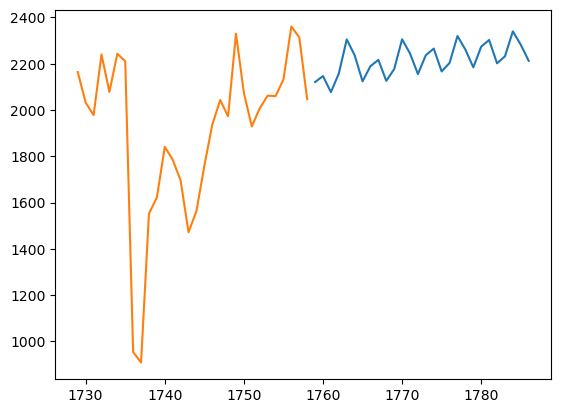

In [34]:
X_train, X_test_len = data[:], 28
model_arima = ARIMA(X_train['val'], order=(5,0,5))
model_arima = model_arima.fit()
model_arima.summary()
start = 0
end = X_train.index[-1] + X_test_len
pred = model_arima.predict(start=start, end=end, typ='levels')
pred.plot(legend=True)
X_train['val'].plot(legend=True)
plt.show()

print(mean_squared_error(X_train['val'][:-2], pred[2:len(X_train)]))

pred[len(data):].plot()
X_train[-30:]['val'].plot()
answer_10766 = pred[len(data):]
test.loc[test['id']==curr_id, 'val'] = answer_10766.to_numpy()
plt.show()

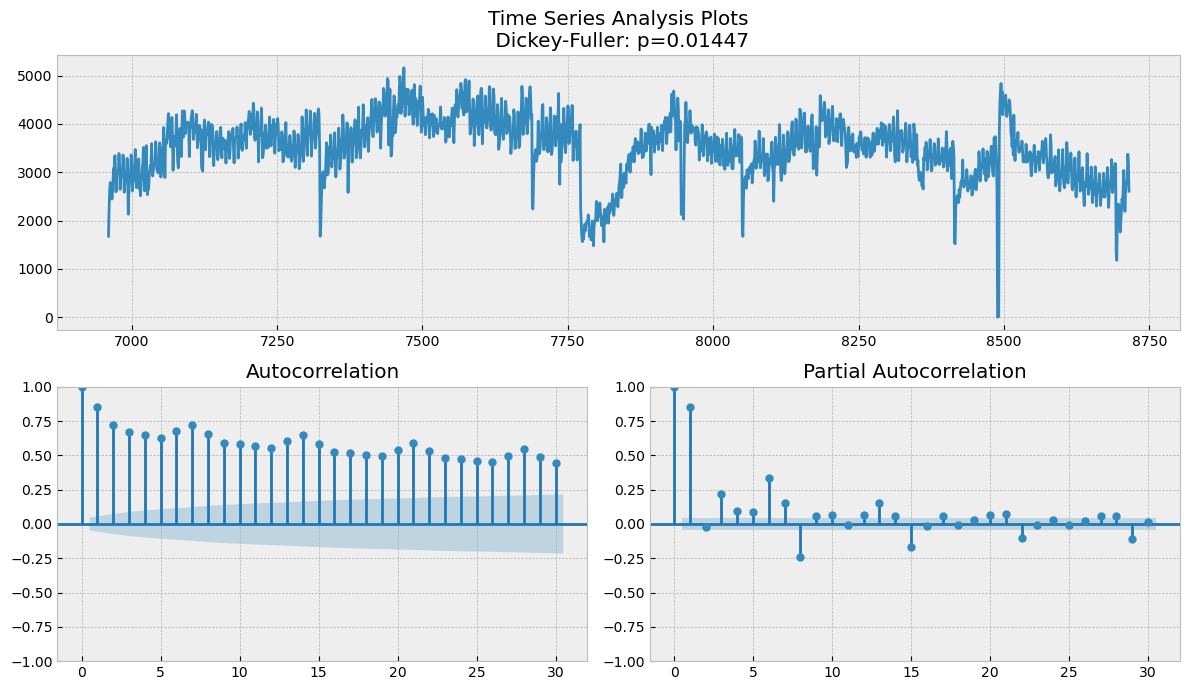

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=24635.058, Time=1.66 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=24943.303, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=24941.162, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=24935.987, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=24941.317, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=24636.747, Time=0.76 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=24634.063, Time=0.77 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=24702.865, Time=0.46 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=24816.114, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=24635.589, Time=1.14 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=24785.635, Time=0.18 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=24638.386, Time=0.57 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=24632.079, Time=0.36 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=24700.877, Time=0.21 sec
 ARIMA(2,1,0)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1726
Model:               SARIMAX(2, 1, 1)   Log Likelihood              -12312.040
Date:                Thu, 16 Mar 2023   AIC                          24632.079
Time:                        00:23:48   BIC                          24653.891
Sample:                             0   HQIC                         24640.148
                               - 1726                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6458      0.021     31.200      0.000       0.605       0.686
ar.L2         -0.2227      0.019    -11.823      0.000      -0.260      -0.186
ma.L1         -0.8494      0.016    -54.024      0.000      -0.880      -0.819
sigma2      9.259e+04   1372.403     67.464      0.000    8.99e+04    9.53e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):             10610.13
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               1.22   Skew:                            -0.93
Prob(H) (two-sided):                  0.02   Kurtosis:                        15.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [35]:
curr_id = 8135
data = pd.DataFrame(train_series[curr_id])
tsplot(data.val, lags=30)
plt.show()
# ряд стационарен
data = data.reset_index()
X_train, X_test = data[:-30], data[-30:]
stepwise_fit = auto_arima(X_train.val, trace=True, suppress_warnings=True,
                         max_P=70, max_d=30)
stepwise_fit.summary()

/home/alex/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


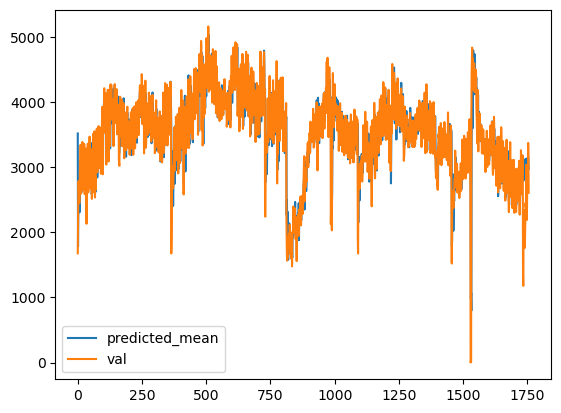

In [36]:
model_arima = ARIMA(X_train['val'], order=(10,0,4))
model_arima = model_arima.fit()
model_arima.summary()
start = len(X_train)
end = len(X_train) + len(X_test) - 1
pred = model_arima.predict(start=start, end=end, typ='levels')

start = 0
end = len(X_train) + len(X_test) - 1
pred = model_arima.predict(start, end)
pred.plot(legend=True)
data['val'].plot(legend=True)
plt.show()

/home/alex/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


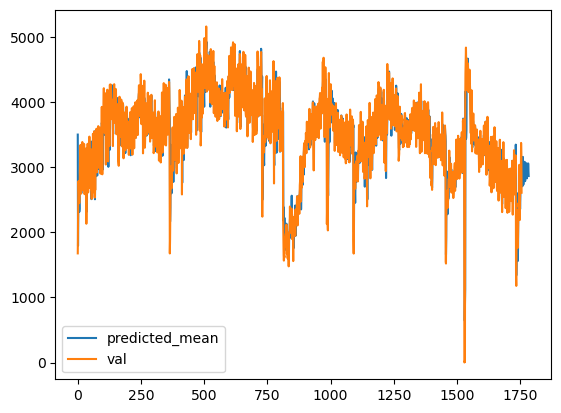

139507.34349339944


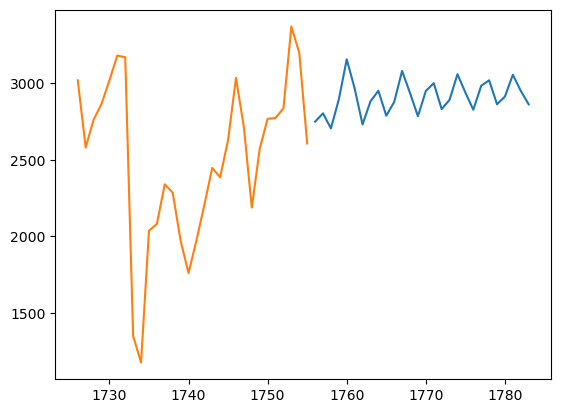

In [37]:
X_train, X_test_len = data[:], 28
model_arima = ARIMA(X_train['val'], order=(10,0,4))
model_arima = model_arima.fit()
model_arima.summary()
start = 0
end = X_train.index[-1] + X_test_len
pred = model_arima.predict(start=start, end=end, typ='levels')
pred.plot(legend=True)
X_train['val'].plot(legend=True)
plt.show()

print(mean_squared_error(X_train['val'][:-2], pred[2:len(X_train)]))

pred[len(data):].plot()
X_train[-30:]['val'].plot()
answer_10766 = pred[len(data):]
test.loc[test['id']==curr_id, 'val'] = answer_10766.to_numpy()
plt.show()

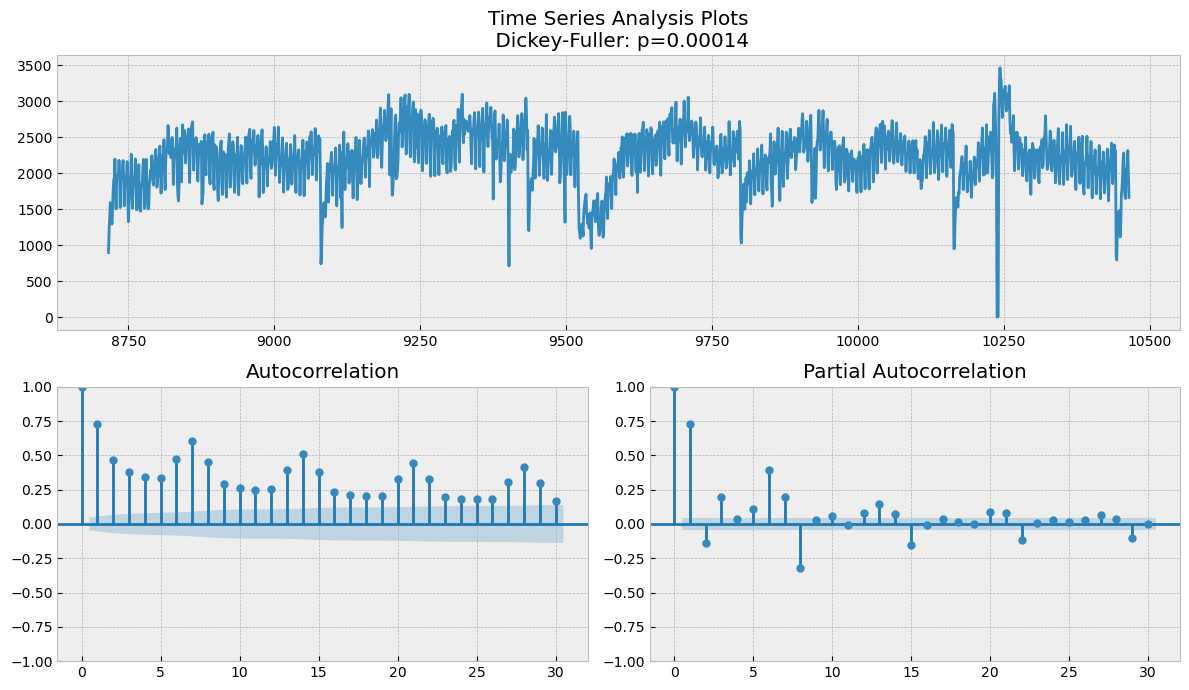

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=23785.238, Time=1.51 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=24226.012, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=24227.628, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=24226.927, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=24224.029, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=23793.505, Time=0.80 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=23786.030, Time=0.71 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=23786.820, Time=1.75 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=23746.231, Time=2.94 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=23773.546, Time=1.79 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=23598.346, Time=2.29 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=23440.325, Time=2.93 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=23756.425, Time=2.54 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=23325.703, Time=2.65 sec
 ARIMA(5,1,2)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1719
Model:               SARIMAX(5, 1, 5)   Log Likelihood              -11601.504
Date:                Thu, 16 Mar 2023   AIC                          23227.007
Time:                        00:25:00   BIC                          23292.394
Sample:                             0   HQIC                         23251.201
                               - 1719                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3306      0.792      0.417      0.676      -1.222       1.883
ar.L1          1.4377      0.039     37.252      0.000       1.362       1.513
ar.L2         -1.9300      0.031    -62.081      0.000      -1.991      -1.869
ar.L3          1.7329      0.050     34.517      0.000       1.635       1.831
ar.L4         -1.4803      0.033    -44.709      0.000      -1.545      -1.415
ar.L5          0.6301      0.032     19.401      0.000       0.566       0.694
ma.L1         -1.6433      0.036    -45.859      0.000      -1.714      -1.573
ma.L2          1.9628      0.036     54.539      0.000       1.892       2.033
ma.L3         -1.9385      0.040    -48.125      0.000      -2.017      -1.860
ma.L4          1.4626      0.038     38.999      0.000       1.389       1.536
ma.L5         -0.7311      0.024    -30.884      0.000      -0.777      -0.685
sigma2      5.087e+04    872.776     58.283      0.000    4.92e+04    5.26e+04
===================================================================================
Ljung-Box (L1) (Q):                   2.24   Jarque-Bera (JB):             24616.67
Prob(Q):                              0.13   Prob(JB):                         0.00
Heteroskedasticity (H):               1.21   Skew:                            -1.26
Prob(H) (two-sided):                  0.02   Kurtosis:                        21.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [38]:
curr_id = 5975
data = pd.DataFrame(train_series[curr_id])
tsplot(data.val, lags=30)
plt.show()
# ряд стационарен
data = data.reset_index()
X_train, X_test = data[:-30], data[-30:]
stepwise_fit = auto_arima(X_train.val, trace=True, suppress_warnings=True,
                         max_P=70, max_d=30)
stepwise_fit.summary()

/home/alex/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


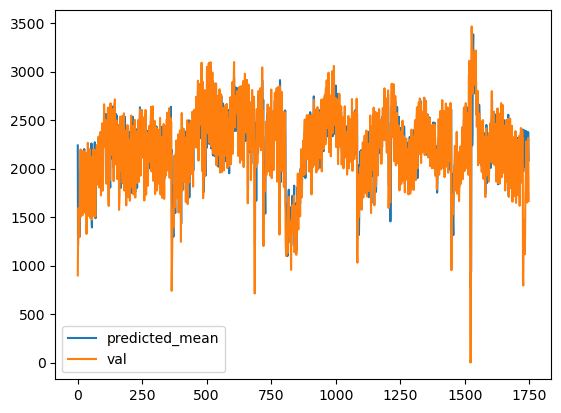

In [39]:
model_arima = ARIMA(X_train['val'], order=(5,0,5))
model_arima = model_arima.fit()
model_arima.summary()
start = len(X_train)
end = len(X_train) + len(X_test) - 1
pred = model_arima.predict(start=start, end=end, typ='levels')

start = 0
end = len(X_train) + len(X_test) - 1
pred = model_arima.predict(start, end)
pred.plot(legend=True)
data['val'].plot(legend=True)
plt.show()

/home/alex/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


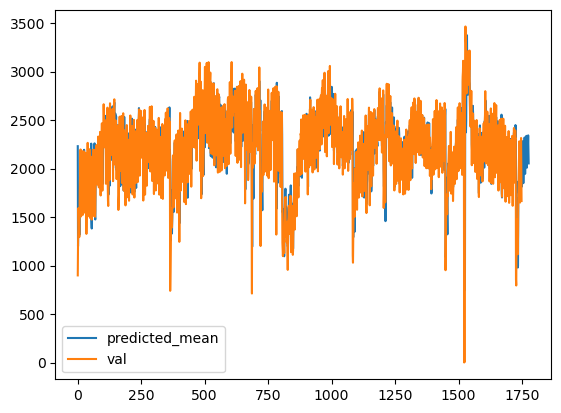

105042.98623840796


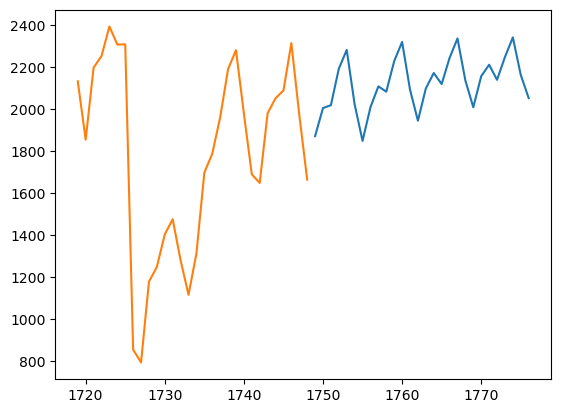

In [40]:
X_train, X_test_len = data[:], 28
model_arima = ARIMA(X_train['val'], order=(5,0,5))
model_arima = model_arima.fit()
model_arima.summary()
start = 0
end = X_train.index[-1] + X_test_len
pred = model_arima.predict(start=start, end=end, typ='levels')
pred.plot(legend=True)
X_train['val'].plot(legend=True)
plt.show()

print(mean_squared_error(X_train['val'][:-2], pred[2:len(X_train)]))

pred[len(data):].plot()
X_train[-30:]['val'].plot()
answer_10766 = pred[len(data):]
test.loc[test['id']==curr_id, 'val'] = answer_10766.to_numpy()
plt.show()

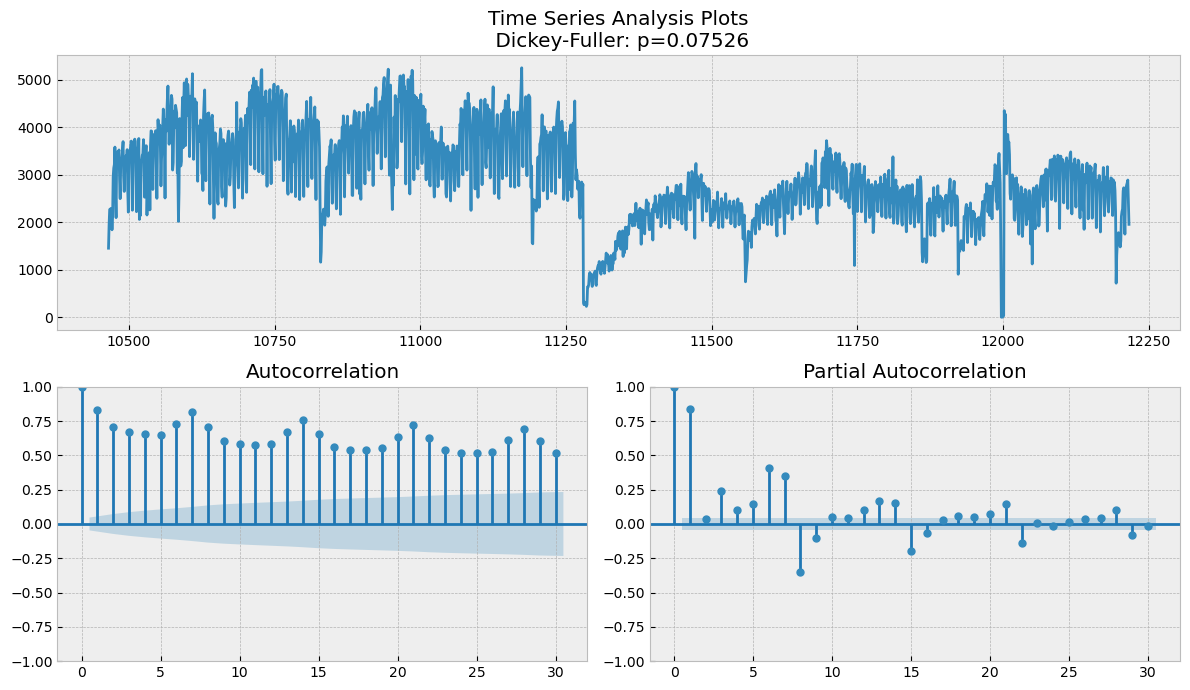

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=26130.388, Time=1.61 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=26571.010, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=26549.131, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=26496.479, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=26569.014, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=26153.317, Time=0.77 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=26147.776, Time=0.81 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=26145.478, Time=1.66 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=25845.476, Time=2.16 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=26151.079, Time=1.56 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=25892.076, Time=2.66 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=25825.299, Time=2.80 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=26148.066, Time=4.16 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=25905.445, Time=4.25 sec
 ARIMA(2,1,5)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1722
Model:               SARIMAX(5, 1, 5)   Log Likelihood              -12693.253
Date:                Thu, 16 Mar 2023   AIC                          25408.506
Time:                        00:26:20   BIC                          25468.463
Sample:                             0   HQIC                         25430.689
                               - 1722                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8721      0.057     15.181      0.000       0.759       0.985
ar.L2         -1.4968      0.047    -32.167      0.000      -1.588      -1.406
ar.L3          0.9078      0.081     11.247      0.000       0.750       1.066
ar.L4         -1.0446      0.046    -22.619      0.000      -1.135      -0.954
ar.L5          0.0797      0.054      1.465      0.143      -0.027       0.186
ma.L1         -1.2978      0.054    -23.964      0.000      -1.404      -1.192
ma.L2          1.7495      0.056     31.314      0.000       1.640       1.859
ma.L3         -1.4694      0.075    -19.613      0.000      -1.616      -1.323
ma.L4          1.2329      0.050     24.780      0.000       1.135       1.330
ma.L5         -0.4970      0.039    -12.589      0.000      -0.574      -0.420
sigma2      1.938e+05   4527.699     42.805      0.000    1.85e+05    2.03e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             12821.02
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.77   Skew:                            -0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [41]:
curr_id = 20857
data = pd.DataFrame(train_series[curr_id])
tsplot(data.val, lags=30)
plt.show()
# ряд стационарен
data = data.reset_index()
X_train, X_test = data[:-30], data[-30:]
stepwise_fit = auto_arima(X_train.val, trace=True, suppress_warnings=True,
                         max_P=70, max_d=30)
stepwise_fit.summary()

/home/alex/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


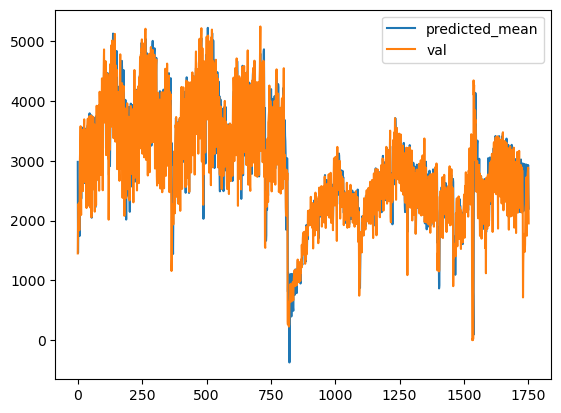

In [42]:
model_arima = ARIMA(X_train['val'], order=(5,0,5))
model_arima = model_arima.fit()
model_arima.summary()
start = len(X_train)
end = len(X_train) + len(X_test) - 1
pred = model_arima.predict(start=start, end=end, typ='levels')

start = 0
end = len(X_train) + len(X_test) - 1
pred = model_arima.predict(start, end)
pred.plot(legend=True)
data['val'].plot(legend=True)
plt.show()

/home/alex/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


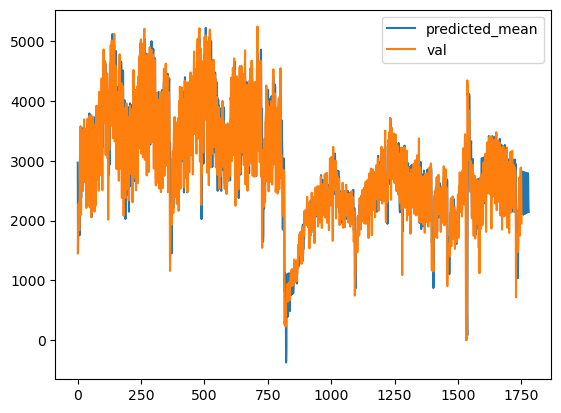

371374.0318235102


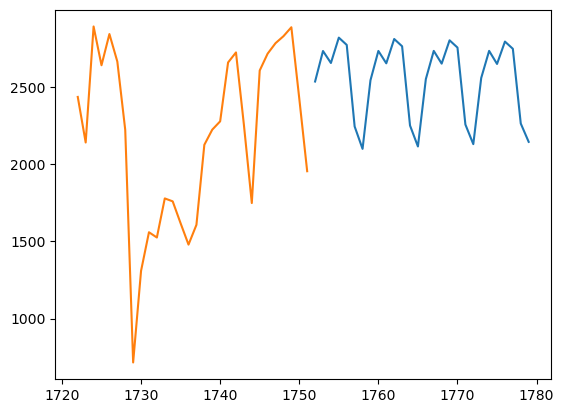

In [43]:
X_train, X_test_len = data[:], 28
model_arima = ARIMA(X_train['val'], order=(5,0,5))
model_arima = model_arima.fit()
model_arima.summary()
start = 0
end = X_train.index[-1] + X_test_len
pred = model_arima.predict(start=start, end=end, typ='levels')
pred.plot(legend=True)
X_train['val'].plot(legend=True)
plt.show()

print(mean_squared_error(X_train['val'][:-2], pred[2:len(X_train)]))

pred[len(data):].plot()
X_train[-30:]['val'].plot()
answer_10766 = pred[len(data):]
test.loc[test['id']==curr_id, 'val'] = answer_10766.to_numpy()
plt.show()

In [44]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196 entries, 0 to 195
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   id      196 non-null    int64         
 1   dt      196 non-null    datetime64[ns]
 2   val     196 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 4.7 KB


# Попробуем RNN
## Ниже функция для обучения основанная на слоу LSTM и двух полносвязных слоев
### А под функцией оценка качества

In [45]:
def predict_RNN(X_train, X_test):
    scaler = MinMaxScaler()
    scaler.fit(X_train['val'].to_numpy().reshape(-1, 1))
    scaled_train = scaler.transform(X_train['val'].to_numpy().reshape(-1, 1))
    
    # generator
    n_input = 120
    n_features = 1
    generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)
    
    model = Sequential()
    model.add((LSTM(128, activation='relu', input_shape=(n_input, n_features))))
    model.add(Dense(64))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

   
    
    model.fit(generator, epochs=24)
    
    last_train_batch = scaled_train[-n_input:]
    last_train_batch = last_train_batch.reshape((1, n_input, n_features))
    
    test_prediction = []
    first_eval_batch = scaled_train[-n_input:]
    current_batch = first_eval_batch.reshape((1, n_input, n_features))

    for i in range(len(X_test)):

        current_predict = model.predict(current_batch)[0]

        test_prediction.append(current_predict)
        current_batch = np.append(current_batch[:, 1:, :], [[current_predict]], axis=1)
        
    preds = np.array(test_prediction)
    preds = scaler.inverse_transform(preds)
    
  
    X_test['preds'] = preds
    X_test[['preds', 'val']].plot()
    plt.show()
    return preds, model
    

In [46]:
rnn_data = pd.DataFrame(data)
rnn_data.drop(['id'], axis=1, inplace=True)
rnn_data = rnn_data.set_index('dt')
X_train, X_test = rnn_data[:-30], rnn_data[-30:]
scaler = MinMaxScaler()

scaler.fit(X_train['val'].to_numpy().reshape(-1, 1))
scaled_train = scaler.transform(X_train['val'].to_numpy().reshape(-1, 1))
scaled_test = scaler.transform(X_test['val'].to_numpy().reshape(-1, 1))

In [47]:
# generator
n_input = 120
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [48]:
model = Sequential()
model.add((LSTM(128, activation='relu', input_shape=(n_input, n_features))))
model.add(Dense(64))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

2023-03-16 00:26:33.564524: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-16 00:26:33.564565: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-16 00:26:33.564590: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Aspire): /proc/driver/nvidia/version does not exist
2023-03-16 00:26:33.564914: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [49]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 74,881
Trainable params: 74,881
Non-trainable params: 0
_________________________________________________________________


In [50]:
model.fit(generator, epochs=24)

Epoch 1/24
1602/1602 [==============================] - 52s 32ms/step - loss: 0.0146
Epoch 2/24
1602/1602 [==============================] - 59s 37ms/step - loss: 0.0116
Epoch 3/24
1602/1602 [==============================] - 59s 37ms/step - loss: 0.0101
Epoch 4/24
1602/1602 [==============================] - 57s 35ms/step - loss: 0.0094
Epoch 5/24
1602/1602 [==============================] - 56s 35ms/step - loss: 0.0087
Epoch 6/24
1602/1602 [==============================] - 57s 35ms/step - loss: 0.0080
Epoch 7/24
1602/1602 [==============================] - 56s 35ms/step - loss: 0.0071
Epoch 8/24
1602/1602 [==============================] - 62s 39ms/step - loss: 0.0066
Epoch 9/24
1602/1602 [==============================] - 56s 35ms/step - loss: 0.0066
Epoch 10/24
1602/1602 [==============================] - 56s 35ms/step - loss: 0.0061
Epoch 11/24
1602/1602 [==============================] - 57s 35ms/step - loss: 0.0059
Epoch 12/24
1602/1602 [==============================] - 55s 35

In [51]:
last_train_batch = scaled_train[-n_input:]
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [52]:
model.predict(last_train_batch)

array([[0.49340633]], dtype=float32)

In [53]:
scaled_test[0]

array([0.46397255])

In [54]:
test_prediction = []
first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(X_test)):
    
    current_predict = model.predict(current_batch)[0]
    
    test_prediction.append(current_predict)
    current_batch = np.append(current_batch[:, 1:, :], [[current_predict]], axis=1)
    

In [55]:
preds = np.array(test_prediction)
preds = scaler.inverse_transform(preds)

<AxesSubplot:xlabel='dt'>

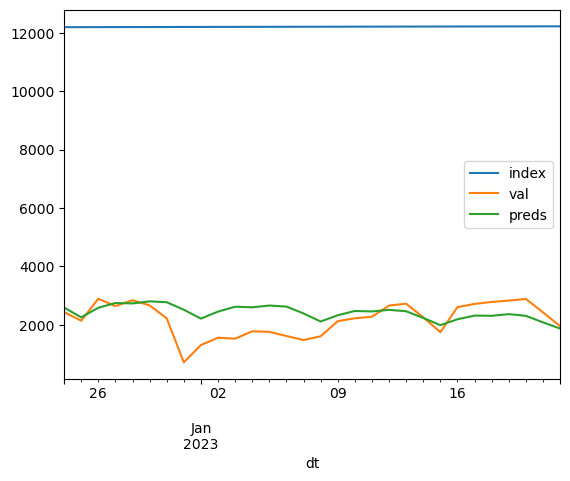

In [56]:
X_test['preds'] = preds
X_test.plot()

## Оценим качество модели с помощья MSE и MAE

In [57]:
mean_squared_error(X_test['val'], X_test['preds']), mean_absolute_error(X_test['val'], X_test['preds'])

(387313.97332419804, 478.89014892578126)

## А теперь предскажем каждый ряд

In [58]:
test['arima_val'] = test.val
test['val'] = np.NaN
model_arr = []

Epoch 1/24
1640/1640 [==============================] - 59s 35ms/step - loss: 0.0043
Epoch 2/24
1640/1640 [==============================] - 57s 35ms/step - loss: 0.0034
Epoch 3/24
1640/1640 [==============================] - 62s 37ms/step - loss: 0.0031
Epoch 4/24
1640/1640 [==============================] - 58s 36ms/step - loss: 0.0030
Epoch 5/24
1640/1640 [==============================] - 56s 34ms/step - loss: 0.0029
Epoch 6/24
1640/1640 [==============================] - 57s 35ms/step - loss: 0.0028
Epoch 7/24
1640/1640 [==============================] - 56s 34ms/step - loss: 0.0028
Epoch 8/24
1640/1640 [==============================] - 56s 34ms/step - loss: 0.0027
Epoch 9/24
1640/1640 [==============================] - 56s 34ms/step - loss: 0.0028
Epoch 10/24
1640/1640 [==============================] - 56s 34ms/step - loss: 0.0026
Epoch 11/24
1640/1640 [==============================] - 56s 34ms/step - loss: 0.0025
Epoch 12/24
1640/1640 [==============================] - 57s 35

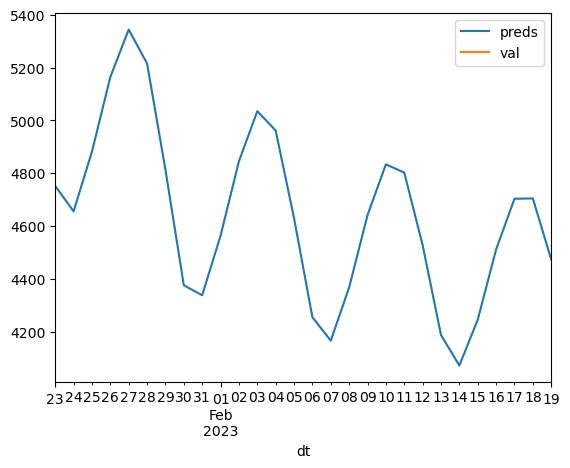

Epoch 1/24
1565/1565 [==============================] - 47s 30ms/step - loss: 0.0176
Epoch 2/24
1565/1565 [==============================] - 45s 29ms/step - loss: 0.0148
Epoch 3/24
1565/1565 [==============================] - 46s 29ms/step - loss: 0.0126
Epoch 4/24
1565/1565 [==============================] - 45s 29ms/step - loss: 0.0114
Epoch 5/24
1565/1565 [==============================] - 46s 29ms/step - loss: 0.0113
Epoch 6/24
1565/1565 [==============================] - 46s 29ms/step - loss: 0.0092
Epoch 7/24
1565/1565 [==============================] - 46s 29ms/step - loss: 0.0076
Epoch 8/24
1565/1565 [==============================] - 46s 29ms/step - loss: 0.0092
Epoch 9/24
1565/1565 [==============================] - 46s 29ms/step - loss: 0.0070
Epoch 10/24
1565/1565 [==============================] - 46s 29ms/step - loss: 0.0066
Epoch 11/24
1565/1565 [==============================] - 46s 29ms/step - loss: 0.0083
Epoch 12/24
1565/1565 [==============================] - 46s 29

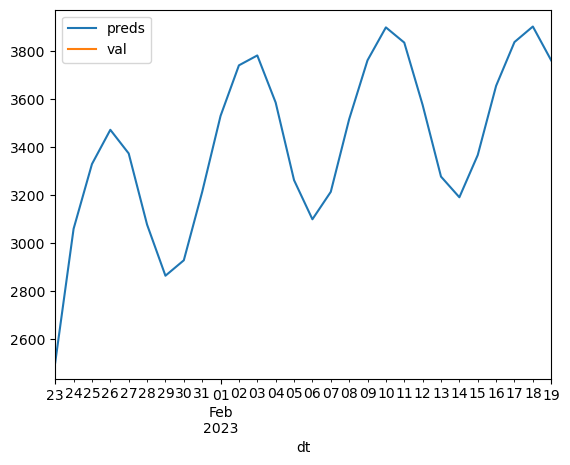

Epoch 1/24
1636/1636 [==============================] - 50s 30ms/step - loss: 0.0088
Epoch 2/24
1636/1636 [==============================] - 50s 31ms/step - loss: 0.0064
Epoch 3/24
1636/1636 [==============================] - 48s 30ms/step - loss: 0.0058
Epoch 4/24
1636/1636 [==============================] - 48s 29ms/step - loss: 0.0051
Epoch 5/24
1636/1636 [==============================] - 48s 29ms/step - loss: 0.0052
Epoch 6/24
1636/1636 [==============================] - 48s 29ms/step - loss: 0.0050
Epoch 7/24
1636/1636 [==============================] - 50s 30ms/step - loss: 0.0049
Epoch 8/24
1636/1636 [==============================] - 48s 29ms/step - loss: 0.0049
Epoch 9/24
1636/1636 [==============================] - 48s 29ms/step - loss: 0.0047
Epoch 10/24
1636/1636 [==============================] - 48s 29ms/step - loss: 0.0048
Epoch 11/24
1636/1636 [==============================] - 48s 29ms/step - loss: 0.0047
Epoch 12/24
1636/1636 [==============================] - 48s 29

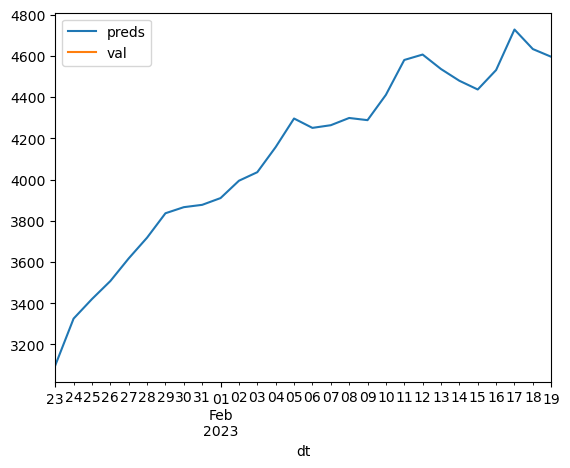

Epoch 1/24
1639/1639 [==============================] - 48s 29ms/step - loss: 0.0082
Epoch 2/24
1639/1639 [==============================] - 48s 29ms/step - loss: 0.0059
Epoch 3/24
1639/1639 [==============================] - 48s 29ms/step - loss: 0.0053
Epoch 4/24
1639/1639 [==============================] - 48s 29ms/step - loss: 0.0052
Epoch 5/24
1639/1639 [==============================] - 48s 29ms/step - loss: 0.0049
Epoch 6/24
1639/1639 [==============================] - 48s 29ms/step - loss: 0.0048
Epoch 7/24
1639/1639 [==============================] - 47s 29ms/step - loss: 0.0047
Epoch 8/24
1639/1639 [==============================] - 48s 29ms/step - loss: 0.0045
Epoch 9/24
1639/1639 [==============================] - 48s 29ms/step - loss: 0.0045
Epoch 10/24
1639/1639 [==============================] - 48s 29ms/step - loss: 0.0044
Epoch 11/24
1639/1639 [==============================] - 48s 29ms/step - loss: 0.0045
Epoch 12/24
1639/1639 [==============================] - 48s 29

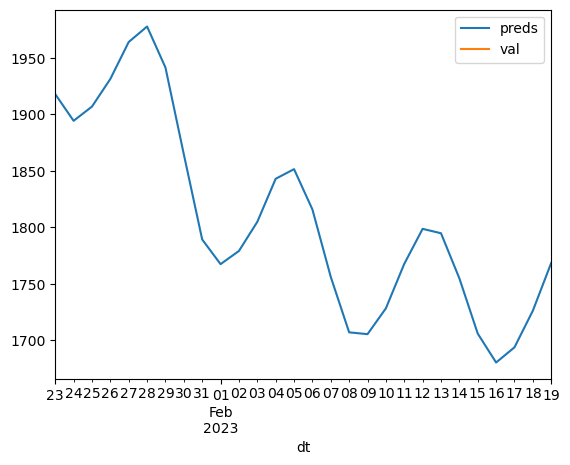

Epoch 1/24
1636/1636 [==============================] - 47s 28ms/step - loss: 0.0076
Epoch 2/24
1636/1636 [==============================] - 46s 28ms/step - loss: 0.0056
Epoch 3/24
1636/1636 [==============================] - 46s 28ms/step - loss: 0.0049
Epoch 4/24
1636/1636 [==============================] - 46s 28ms/step - loss: 0.0048
Epoch 5/24
1636/1636 [==============================] - 46s 28ms/step - loss: 0.0044
Epoch 6/24
1636/1636 [==============================] - 46s 28ms/step - loss: 0.0044
Epoch 7/24
1636/1636 [==============================] - 46s 28ms/step - loss: 0.0044
Epoch 8/24
1636/1636 [==============================] - 45s 28ms/step - loss: 0.0043
Epoch 9/24
1636/1636 [==============================] - 46s 28ms/step - loss: 0.0044
Epoch 10/24
1636/1636 [==============================] - 46s 28ms/step - loss: 0.0042
Epoch 11/24
1636/1636 [==============================] - 46s 28ms/step - loss: 0.0041
Epoch 12/24
1636/1636 [==============================] - 46s 28

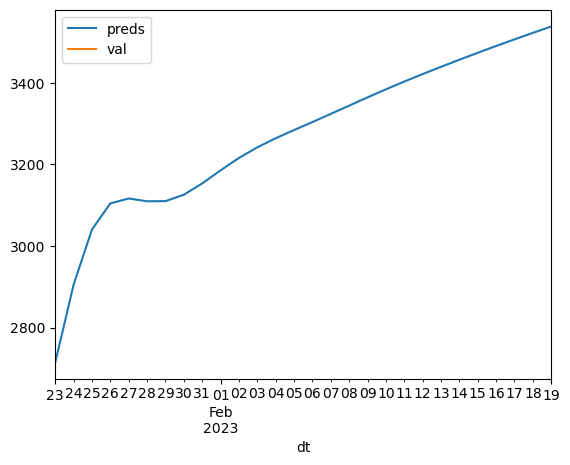

Epoch 1/24
1629/1629 [==============================] - 47s 28ms/step - loss: 0.0101
Epoch 2/24
1629/1629 [==============================] - 46s 28ms/step - loss: 0.0079
Epoch 3/24
1629/1629 [==============================] - 46s 28ms/step - loss: 0.0064
Epoch 4/24
1629/1629 [==============================] - 46s 28ms/step - loss: 0.0064
Epoch 5/24
1629/1629 [==============================] - 46s 28ms/step - loss: 0.0062
Epoch 6/24
1629/1629 [==============================] - 46s 28ms/step - loss: 0.0060
Epoch 7/24
1629/1629 [==============================] - 46s 28ms/step - loss: 0.0058
Epoch 8/24
1629/1629 [==============================] - 46s 28ms/step - loss: 0.0057
Epoch 9/24
1629/1629 [==============================] - 46s 28ms/step - loss: 0.0055
Epoch 10/24
1629/1629 [==============================] - 46s 28ms/step - loss: 0.0057
Epoch 11/24
1629/1629 [==============================] - 48s 29ms/step - loss: 0.0054
Epoch 12/24
1629/1629 [==============================] - 46s 28

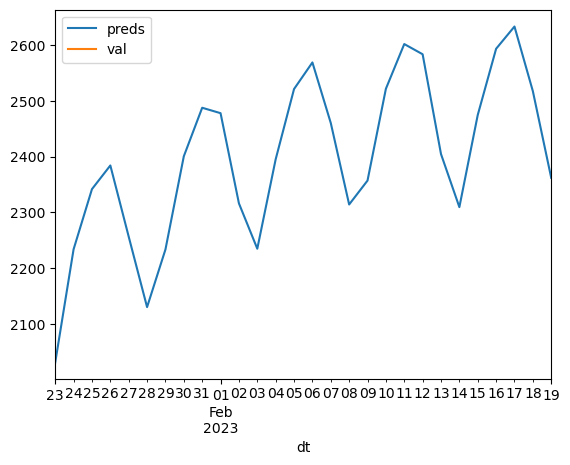

Epoch 1/24
1632/1632 [==============================] - 47s 28ms/step - loss: 0.0141
Epoch 2/24
1632/1632 [==============================] - 46s 28ms/step - loss: 0.0120
Epoch 3/24
1632/1632 [==============================] - 46s 28ms/step - loss: 0.0109
Epoch 4/24
1632/1632 [==============================] - 46s 28ms/step - loss: 0.0098
Epoch 5/24
1632/1632 [==============================] - 46s 28ms/step - loss: 0.0094
Epoch 6/24
1632/1632 [==============================] - 46s 28ms/step - loss: 0.0089
Epoch 7/24
1632/1632 [==============================] - 46s 28ms/step - loss: 0.0081
Epoch 8/24
1632/1632 [==============================] - 46s 28ms/step - loss: 0.0081
Epoch 9/24
1632/1632 [==============================] - 46s 28ms/step - loss: 0.0069
Epoch 10/24
1632/1632 [==============================] - 46s 28ms/step - loss: 0.0068
Epoch 11/24
1632/1632 [==============================] - 46s 28ms/step - loss: 0.0069
Epoch 12/24
1632/1632 [==============================] - 46s 28

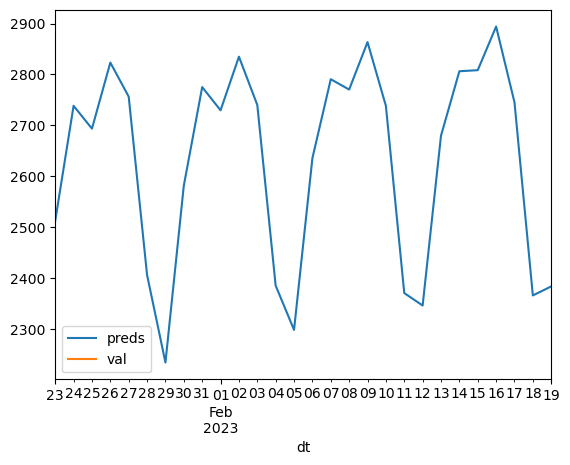

In [59]:
for id_s in train_series:
    data = train_series[id_s]
    X_train = pd.DataFrame(data).drop(['id'],axis=1).set_index('dt')
    X_test = test[test.id==id_s].set_index('dt')
    preds, model = predict_RNN(data, X_test)
    answer_10766 = preds.reshape(28)
    answer_10766.shape, test[test.id==id_s].shape
    model_arr.append(model)
    test.loc[test['id']==id_s, 'val'] = answer_10766

In [60]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196 entries, 0 to 195
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   id         196 non-null    int64         
 1   dt         196 non-null    datetime64[ns]
 2   val        196 non-null    float64       
 3   arima_val  196 non-null    float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 6.2 KB


In [61]:

tmp = test[test.id == 5819]

In [62]:
train_series.keys()

dict_keys([10766, 5819, 10121, 3216, 8135, 5975, 20857])

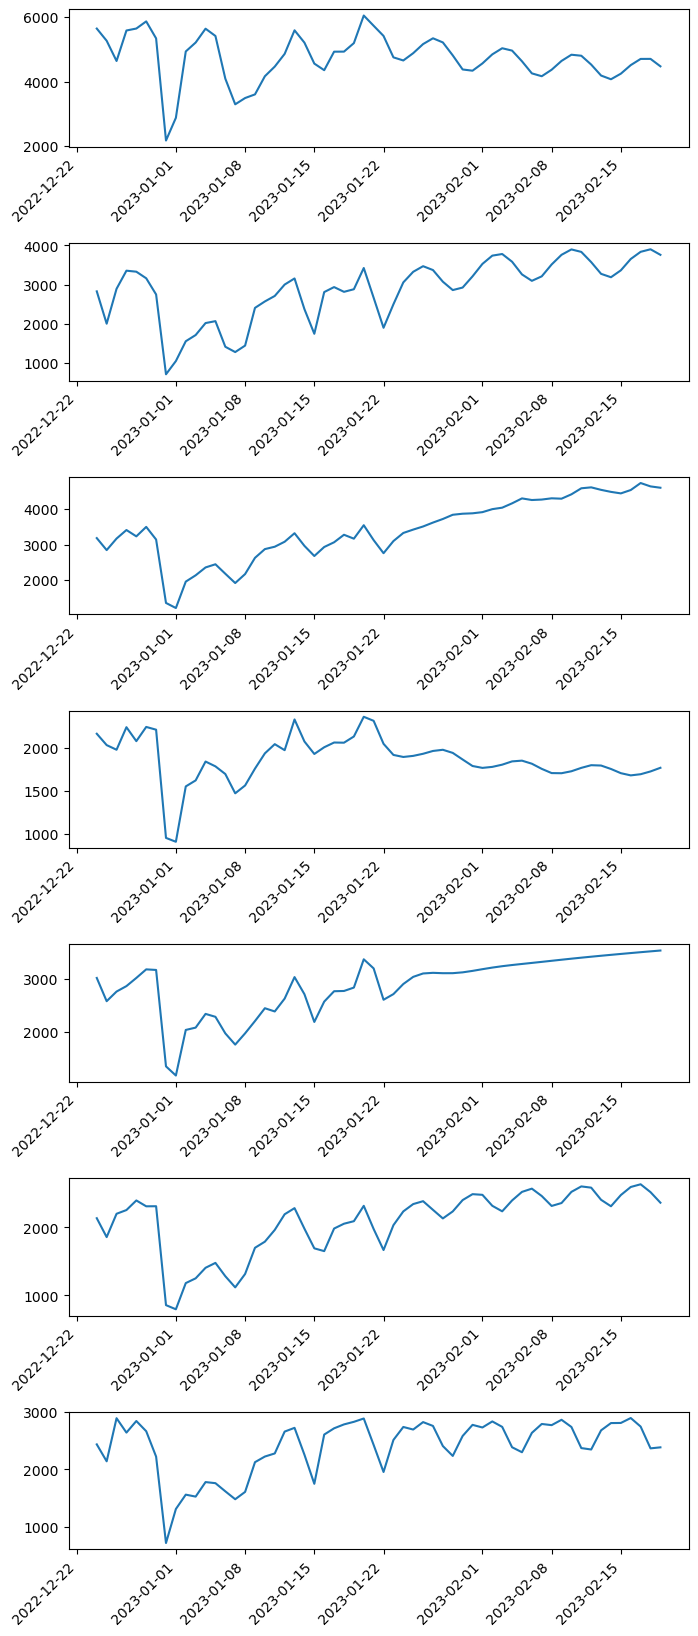

In [63]:
fig, axes = plt.subplots(7, 1, figsize=(8, 20))
i = 0
fig.subplots_adjust(hspace=0.7)
axes = axes.flatten()
for id_s in train_series:
    data = pd.DataFrame(train_series[id_s])
    
    data = data.set_index('dt')
    array = data['val'][-30:].to_list()
    array += test[test.id==id_s]['val'].to_list()
    times = list(data[-30:].index) + test[test.id==id_s]['dt'].to_list()
    sns.lineplot(x=times, y=array, ax=axes[i])
    
    i+=1
for ax in axes:
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

plt.show()
    
    

In [ ]:
test.to_csv('./submission.csv')

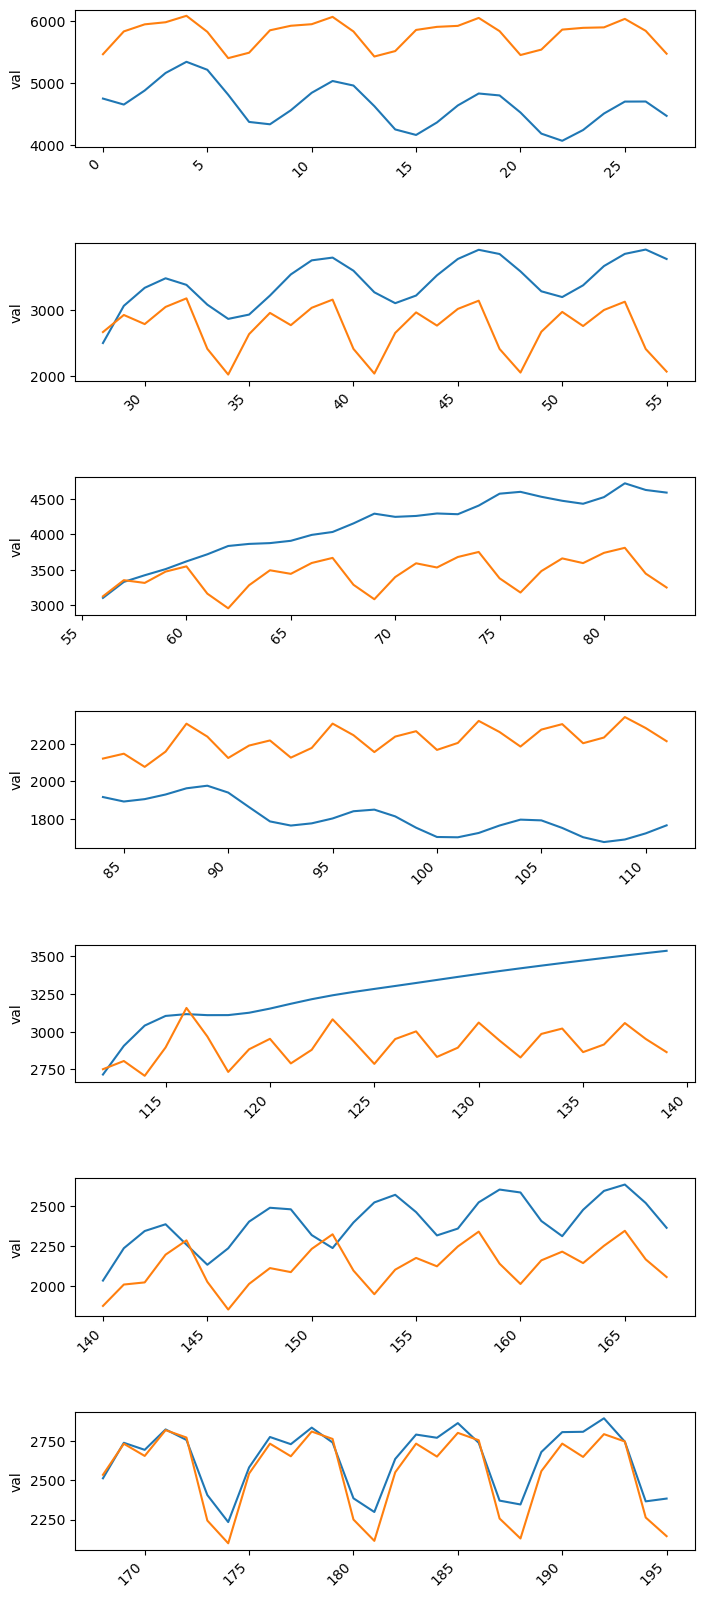

In [69]:
fig, axes = plt.subplots(7, 1, figsize=(8, 20))
i = 0
fig.subplots_adjust(hspace=0.7)
axes = axes.flatten()
for id_s in train_series:
    data = pd.DataFrame(test[test.id == id_s])
    sns.lineplot(data['val'], ax=axes[i])
    sns.lineplot(data['arima_val'], ax=axes[i])
    i += 1
for ax in axes:
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    
plt.show()

In [75]:
test['mean_val'] = (test['val'] + test['arima_val'])/2

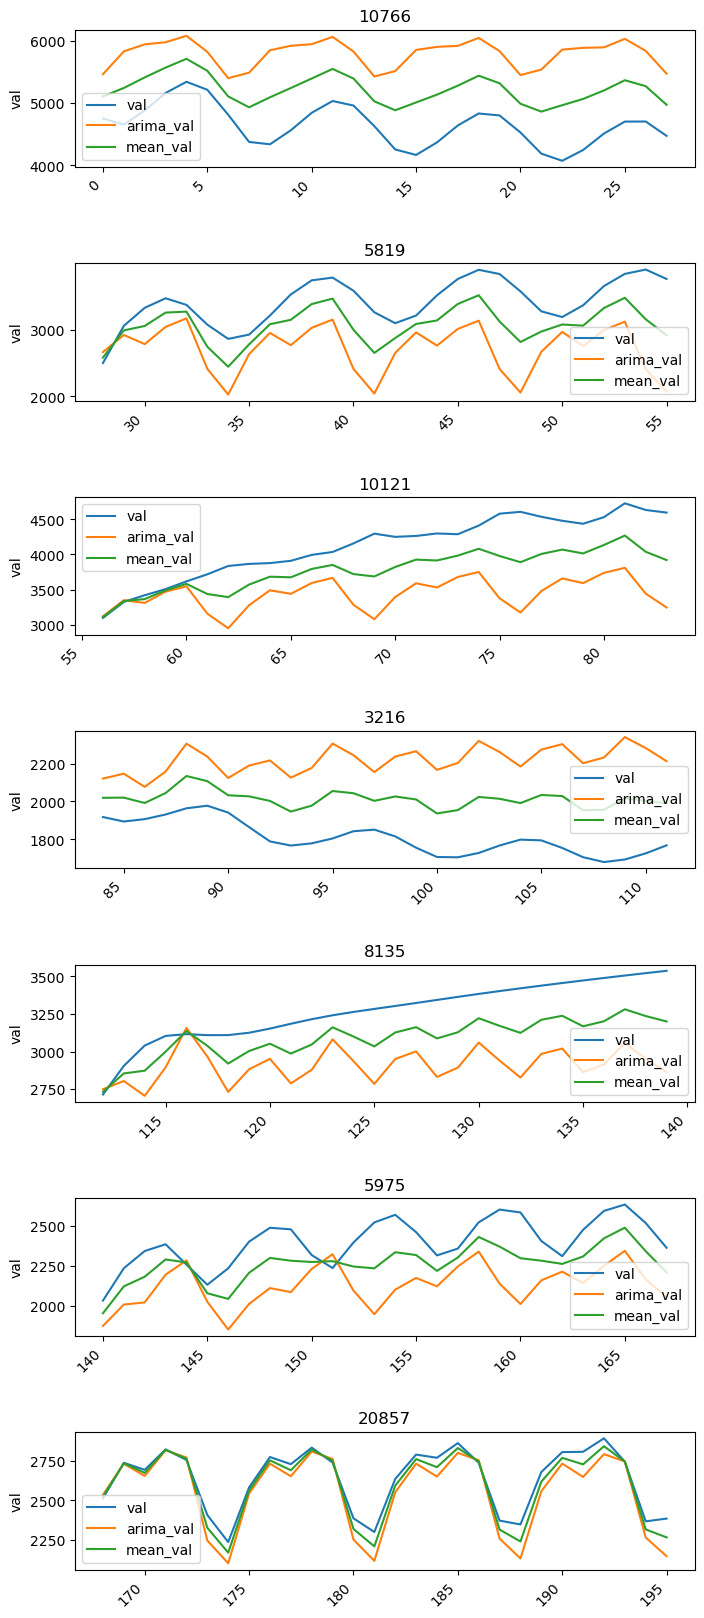

In [81]:
fig, axes = plt.subplots(7, 1, figsize=(8, 20))
i = 0
fig.subplots_adjust(hspace=0.7)
axes = axes.flatten()
for id_s in train_series:
    data = pd.DataFrame(test[test.id == id_s])
    sns.lineplot(data['val'], ax=axes[i], label='val')
    sns.lineplot(data['arima_val'], ax=axes[i], label='arima_val')
    sns.lineplot(data['mean_val'], ax=axes[i], label='mean_val')
    axes[i].set_title(id_s)
    
    i += 1
for ax in axes:
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    
plt.show()


In [78]:
test['final_val'] = np.NaN

In [87]:
test.loc[test['id']==10766, 'final_val'] = test[test.id == 10766]['mean_val']
test.loc[test['id']==5819, 'final_val'] = test[test.id == 5819]['mean_val']
test.loc[test['id']==10121, 'final_val'] = test[test.id == 10121]['mean_val']
test.loc[test['id']==3216, 'final_val'] = test[test.id == 3216]['val']
test.loc[test['id']==8135, 'final_val'] = test[test.id == 8135]['mean_val']
test.loc[test['id']==5975, 'final_val'] = 0.3*test[test['id']==5975]['arima_val']+0.7*test[test['id']==5975]['val']
test.loc[test['id']==20857, 'final_val'] = test[test.id == 20857]['mean_val']

In [77]:
train_series.keys()

dict_keys([10766, 5819, 10121, 3216, 8135, 5975, 20857])

<AxesSubplot:ylabel='arima_val'>

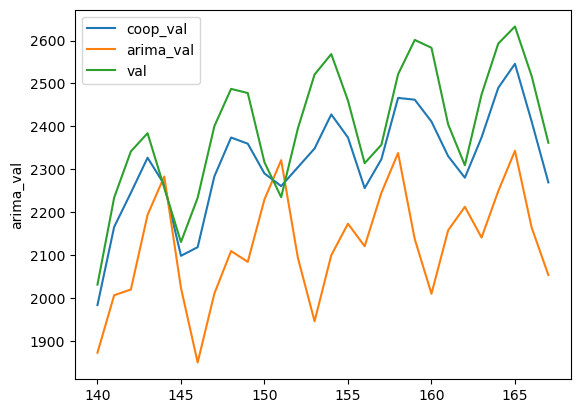

In [86]:
sns.lineplot(0.3*test[test['id']==5975]['arima_val']+0.7*test[test['id']==5975]['val']
             , label='coop_val')
sns.lineplot(test[test['id']==5975]['arima_val'] , label='arima_val')
sns.lineplot(test[test['id']==5975]['val']
             , label='val')

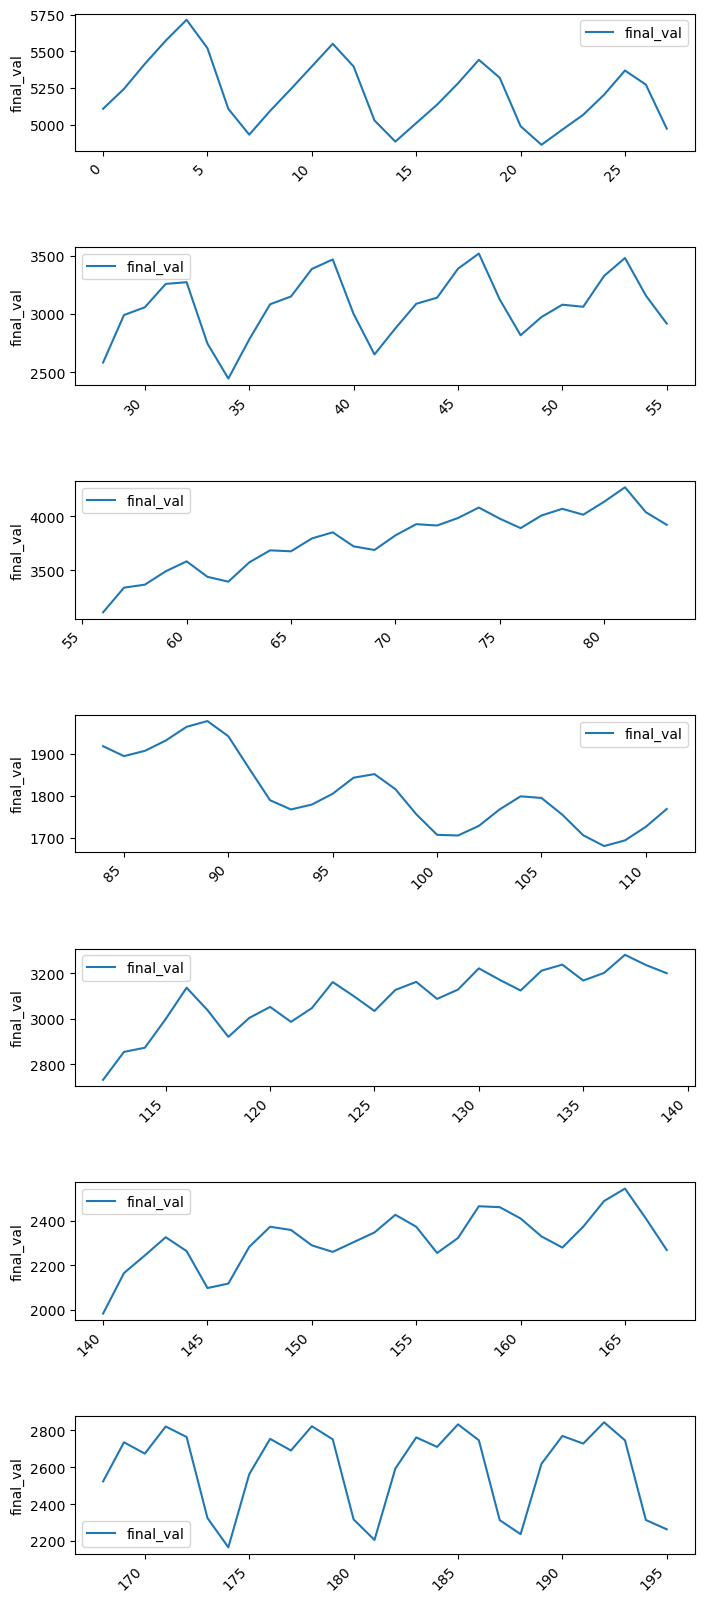

In [88]:
fig, axes = plt.subplots(7, 1, figsize=(8, 20))
i = 0
fig.subplots_adjust(hspace=0.7)
axes = axes.flatten()
for id_s in train_series:
    data = pd.DataFrame(test[test.id == id_s])
    sns.lineplot(data['final_val'], ax=axes[i], label='final_val')
    i += 1
for ax in axes:
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    
plt.show()

In [89]:
test.columns

Index(['id', 'dt', 'val', 'arima_val', 'mean_val', 'final_val'], dtype='object')

In [90]:
submission = pd.DataFrame(test[['id', 'dt', 'final_val']])
submission

,id,dt,final_val
0,10766,2023-01-23,5109.054744
1,10766,2023-01-24,5244.509793
2,10766,2023-01-25,5414.706142
3,10766,2023-01-26,5572.780269
4,10766,2023-01-27,5714.781692
...,...,...,...
191,20857,2023-02-15,2728.392726
192,20857,2023-02-16,2843.696451
193,20857,2023-02-17,2745.892350
194,20857,2023-02-18,2314.209579


In [91]:
submission.to_csv('submission.csv', index=False)

In [93]:
tmp = pd.read_csv('test.csv')
tmp

,id,dt
0,10766,2023-01-23
1,10766,2023-01-24
2,10766,2023-01-25
3,10766,2023-01-26
4,10766,2023-01-27
...,...,...
191,20857,2023-02-15
192,20857,2023-02-16
193,20857,2023-02-17
194,20857,2023-02-18
